# Fonction tester

This file main goal is to test function and classes for later use in training.
Is ignore entirely during the training

### Import Lib

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import AE_Generator, Full_Diff_Generator, Basic_Generator, FLX_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch, F_and_plots, Plot_triple_diff_separated
from CST import CST

data_folder=  'Data3'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)
######
seed=0
batch_size=32
np.random.seed(seed)

def identity(x):
    return(x)

def Log(x): 
    return(np.log(1 - x + 0.1))

def Log(x): 
    return(np.log(1 - x + 0.1))# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import AE_Generator, Full_Diff_Generator, Basic_Generator, FLX_Generator, CloudyGenerator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Plot_Batch, F_and_plots, Plot_triple_diff_separated
from CST import CST

data_folder=  'Data2'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)
######
seed=0
batch_size=32
np.random.seed(seed)

def identity(x):
    return(x)

def Log(x): 
    return(np.log(1 - x + 0.1))

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Prepross

In [2]:
#D = [Load_FLX_dict('DictPrepross2.hdf5')]
#normal_generator = Basic_Generator(folder=data_folder, batch_size=batch_size*500, custom_b_p_e=100)
#D[0].fitonGen(normal_generator, axis=1)
#del(normal_generator)

In [3]:
#X = D[0].to_array_save()
#X.to_hdf('DictPrepross2.hdf5', key='s')

In [4]:
#X = D[0].to_array_save()
#D[0].to_hdf('DictPrepross2.hdf5', key='s')

In [5]:
from utils import Load_FLX_dict, read_Level_Norm

D=[Load_FLX_dict('DictPrepross2.hdf5')]
del(D[0].dict['ts'])
D2 = [DictPrepross(['o3','pl','q'],
     [Level_Normalizer(False), Level_Normalizer(False), Level_Normalizer(False)] )]
d = read_Level_Norm('dict0.txt')

for k in D2[0].dict.keys():
    D2[0][k].L = d[k]
    D2[0][k].fitted=True

In [6]:
# V
V = [VarSuppression(['ts', 'frocean', 'frlake','frland','frlandice', 'frseaice'])]
V = [VarSuppression(['ts'])]
Klist=[]
##### Full Preprocessing :
FP = D + Klist + D2 + V

##### b_size
train_generator =  FLX_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=V, chosen_var=['flxd', 'flxu'], shuffle=0)
#validation_generator =  FLX_Generator(folder=data_folder, batch_size=batch_size, train=False, 
#                                         preprocess_x=V, chosen_var=['flxd', 'flxu'], shuffle=0)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

In [7]:
import keras
import tensorflow as tf

def MakeDictMatrix(D, header, lev=72):
    """
    from a preproc dictionnary return two matrix, one for substraction one for multiplication
    Doing (X-M1)*M2 is equivalent to applying the preproc normalisation
    """ 
    Ms = np.zeros((1, lev, len(header)))
    Mp = np.ones((1, lev, len(header)))
    for var in D.dict.keys():
        i = header.index(var)
        Ms[0, :, i] = D[var].sub_vec(lev)
        Mp[0, :, i] = D[var].prod_vec(lev)
    return(Ms,Mp)

def MakeDictNet(Ms,Mp):
    Ts1 = tf.cast(Ms, dtype=tf.float32)
    Tp1 = tf.cast(Mp, dtype=tf.float32)
    D1s = lambda x : keras.layers.Subtract()([x, Ts1])
    D1m = lambda x : keras.layers.Multiply()([x, Tp1])
    lbd_D1s = keras.layers.Lambda(D1s)
    lbd_D1m = keras.layers.Lambda(D1m)   
    M = keras.Sequential()
    M.add(lbd_D1s)
    M.add(lbd_D1m)
    return(M)

M,P = MakeDictMatrix(D[0], header_x)
M_norm_1 = MakeDictNet(M,P)
M,P = MakeDictMatrix(D2[0], header_x)
M_norm_2 =  MakeDictNet(M,P)

### Model construction : Unet

In [8]:
import keras

from architectures import AE, Unet_Act_Double
from architectures_simples import Upsampler, Divide_Recombine, Divide_Substract
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras.layers import Dense, Flatten, Reshape, Lambda, Input

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

lev=72
reg=10e-5
list_of_filters_ae =  [[32, 64, 64, 128], 
                       [30, 30, 50, 50, 128, 128], 
                       [40, 10], 
                       [64, 64, 128, 128, 128, 128], 
                       [256, 32, 2]]

list_of_kernel_ae =  [[10, 10, 5, 5], 
                      [2, 5, 2, 5, 2, 4], 
                      [], 
                      [3, 4, 3, 5, 3, 6], 
                      [10, 5, 3]]

list_of_activations_ae =  [['elu', 'elu', 'elu', 'elu'], 
                            ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], 
                            ['tanh', 'tanh', 'tanh'], 
                            ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], 
                            ['elu', 'elu', 'linear']]

params_ae = [0.01]
M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_unet =  Unet_Act_Double(list_of_kernel_ae, list_of_filters_ae, list_of_activations_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel, reg=1e-7)
#M_f =Divide_Substract(o_channel, list_of_filters_ae[-1][-1], lev=lev,reg=1e-7)
#M_f.trainable = False

Sub_f = lambda x: x[:,:,0] - x[:,:,1]
Sub = keras.layers.Lambda(Sub_f)
#model = keras.Model(Input0, Sub)

M0 = keras.models.Sequential()
M0.add(M_Up); M0.layers[-1].name = 'Upsampler'
M0.add(M_unet); M0.layers[-1].name = 'Unet'
#M.add(M_f); M.layers[-1].name = 'Div_Rec'
M0.add(Sub); M0.layers[-1].name = 'Substract'
#M.add(Flatten())
M0.summary()
M0.load_weights('BestModels/Best_Unet(serveur)')

M = keras.models.Sequential()
M.add(M_norm_1)
M.add(M_norm_2)
M.add(M0)

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures_simples.py:27: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", strides=5)`
  Avg = AveragePooling1D(pooling, padding='same', stride=avg)(Up)
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:143: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_100", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:143: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_101", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:143: UserWarning: Update your `Av

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 10)            0         
_________________________________________________________________
Unet (Model)                 (None, 72, 2)             1336146   
_________________________________________________________________
Substract (Lambda)           (None, 72)                0         
Total params: 1,336,146
Trainable params: 1,336,146
Non-trainable params: 0
_________________________________________________________________


#  Model Construction : FullyConv

In [9]:
import keras

from architectures import AE, Unet_Act_Double, Bidir_Casual_Conv
from architectures_simples import Upsampler, Divide_Recombine, Divide_Substract
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras.layers import Dense, Flatten, Reshape, Lambda, Input

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

lev=72
reg=10e-7
list_of_filters =  [[32, 64, 64, 128, 128, 150], 
                       [32, 64, 128, 128], 
                       [256, 256, 64, 2]] 

list_of_kernels =  [[72, 72, 30, 10, 5, 3], 
                      [72, 30, 5, 3], 
                      [10, 10, 5, 3]]

list_of_activations =  [['elu','elu','elu','elu','elu','elu'], 
                            ['elu','elu','elu','elu',], 
                            ['elu', 'swish', 'swish', 'linear']]
#[['swish', 'swish', 'swish', 'swish','swish'], 
#                            ['swish', 'swish', 'swish', 'swish'], 
#                            ['swish', 'swish', 'swish', 'linear']]

#params_ae = [0.01]
params_ae = [0.01]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_BD = Bidir_Casual_Conv(list_of_kernel_s=list_of_kernels, 
                         list_of_filters=list_of_filters, 
                         list_of_activations=list_of_activations, 
                         params=params_ae, 
                         in_channel=in_channel,
                         reg=reg )
Sub_f = lambda x: x[:,:,0] - x[:,:,1]
Sub = keras.layers.Lambda(Sub_f)

M1 = keras.models.Sequential()
#M.add(M_Up); M.layers[-1].name = 'Upsampler'
M1.add(M_norm_1); M.layers[-1].name = 'Norm1'
M1.add(M_BD); M.layers[-1].name = 'Conv_BD'
M1.add(Sub); M.layers[-1].name = 'Substract'
M1.load_weights('BestModels/FullyConv1epoch')

In [10]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime

def Up_Down_loss(y_true, y_pred):
    return(mean_squared_error(y_true, y_pred))

#ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, restore_best_weights=True)
#prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = 'UNet_Double'

#LH = LossHistory(frequency=train_generator.batch_per_file, losses=['loss'])
#Adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-7, amsgrad=False)
#M.compile(loss = Up_Down_loss, optimizer=Adam, metrics=[Up_Down_loss] )
#M.summary()

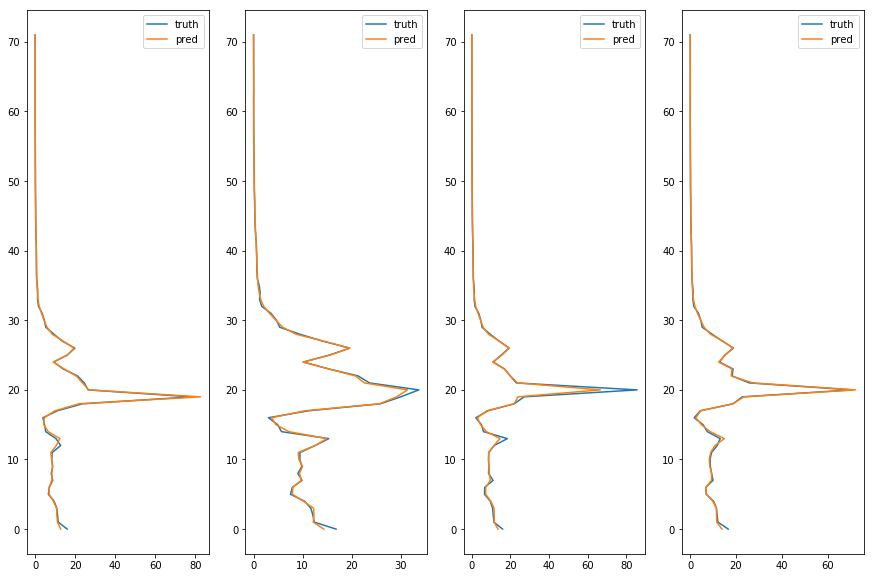

In [11]:
from utils import F_and_plots, Plot_diff


def medium_pred(Mlist,x):
    for i,m in enumerate(Mlist):
        if i>0:
            y=y+m.predict(x)
        else:
            y=m.predict(x)
    return(y/len(Mlist))
    
i=np.random.randint(len(train_generator))
x,y=train_generator[i]
y0 = medium_pred([M,M1],x)
y0 = np.expand_dims(y0,axis=-1)
y = np.expand_dims(y,axis=-1)
J=np.arange(4)
Plot_diff( F_and_plots(shape=(1,len(J))), y,y0, header_y=['flx'], J=J)

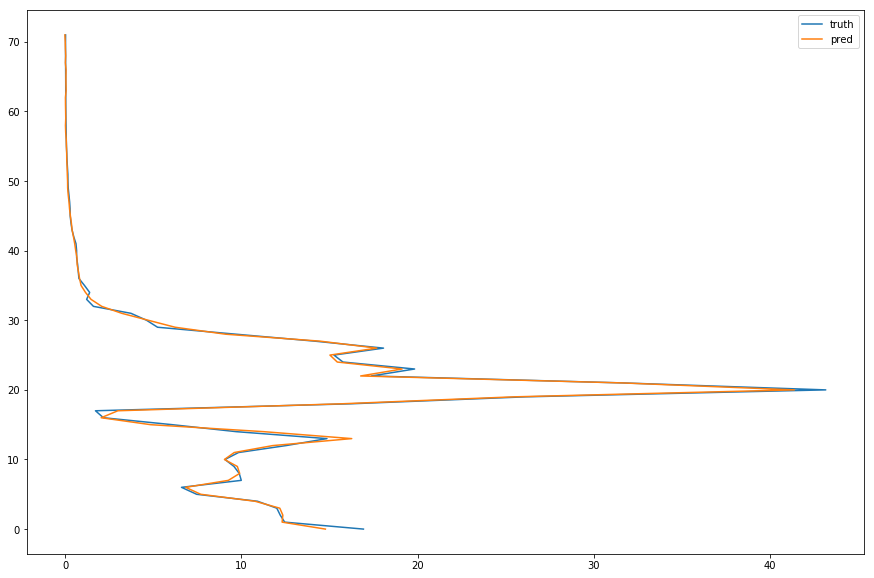

In [12]:
Plot_diff( F_and_plots(shape=(1,1)), y,y0, header_y=['flx'], J=[4])

In [24]:
X,Y = train_generator[5000]
Y0 = (M.predict(X)+M1.predict(X))/2
xmin = X[[300]]
del(X,Y)

IndexError: index 5000 is out of bounds for axis 0 with size 32

In [15]:
# Use input
# ---------
from netCDF4 import Dataset
import numpy as np

path = 'Data_net4/Jacobians/'
fields3d = ['dflxdpl','dflxdt','dflxdq','dflxdqi','dflxdql','dflxdri','dflxdrl',
            'dflxdo3','dflxdfcld',
            'dfdtsdpl','dfdtsdt','dfdtsdq','dfdtsdqi','dfdtsdql','dfdtsdri','dfdtsdrl',
            'dfdtsdo3','dfdtsdfcld']

fields2d = ['dflxdts','dflxdemis','dfdtsdts','dfdtsdemis']

# Open NetCDF file for reading
F = Dataset('Data_net4/401_600/f522_dh.trainingdata_in.lcv.20190401_0600z.nc4')

def Produce_netCDF4_jacobian(fh, header_x):
    z = np.arange(1, 73, 1)
    flag=True
    J2 = np.expand_dims(np.array(fh['dflxdpl']).T, axis=0) 
    # first var is emis and a 2d var not shown anyway, so we use 
    for v0 in header_x:
        v = 'dflxd'+v0
        if 'flx' in v and not 'emis' in v and not 'ts' in v:
            if flag:
                J2 = np.concatenate([J2 , np.expand_dims(np.array(fh[v]).T, axis=0)], axis=0)
            else:
                J2 = np.array(np.expand_dims(fh[v], axis=0))
                flag=True
    return(J2)

def Profile_to_Generator(gen, i1, j1):
    # IS NOT WORKING PROPERLY use produce_xnc4 
    """
    given indices i and j for fortran code, this returns two ids such that gen[id1][:][id2] is the same profile
    gen_dim : dimensions method of generator with suffle==0, len(Listdir)==1
    i, x id
    j, y id
    """
    i=i1-1
    j=j1-1
    x=gen.dimensions['x']
    y=gen.dimensions['y']
    (x_id,y_id) = (i//x, j//y)
    (in_file_x_id, in_file_y_id) = (i%x, j%y)
    File_id = x_id+y_id*5
    el_id = in_file_x_id*x + in_file_y_id
    el_batch = el_id//gen.batch_size
    print( File_id, el_batch)
    id = gen.ids_to_index([0, File_id, el_batch])
    return id, el_id%gen.batch_size

def Produce_x_nc4(fh, i0,j0, header_x):
    z = np.arange(1, 73, 1)
    flag=True
    x_0 = np.zeros((72, len(header_x)))
    for i,v in enumerate(header_x):
        if v=='emis':
            x_0[:,i] = fh.variables[v][0,j0-1,i0-1]
        if not 'emis' in v and not 'ts' in v:
            x_0[:,i] = fh.variables[v][0,:,j0-1,i0-1]
    return(x_0)

def file_name_to_id(fname):
#    fn, ex = fname.split('.')
    _, istr, jstr = fname.split('_')
    i = int(istr[1:])
    j = int(istr[1:])
    return(i,j)

J_fortran = []
profiles = []

for j in os.listdir(path):
    ex = j.split('.')[-1]
    if(ex=='nc4'):
        profiles.append(j.split('.')[0])

ids_profiles = [ file_name_to_id( profile) for profile in profiles]

xnc4 = np.zeros((len(profiles),lev, len(header_x)))
for i,profile in enumerate(profiles):
    fh = Dataset(path+profile+'.nc4')
    J_fortran.append(Produce_netCDF4_jacobian(fh, header_x))
    xnc4[i] = Produce_x_nc4(F, ids_profiles[i][0], ids_profiles[i][1], header_x)
    

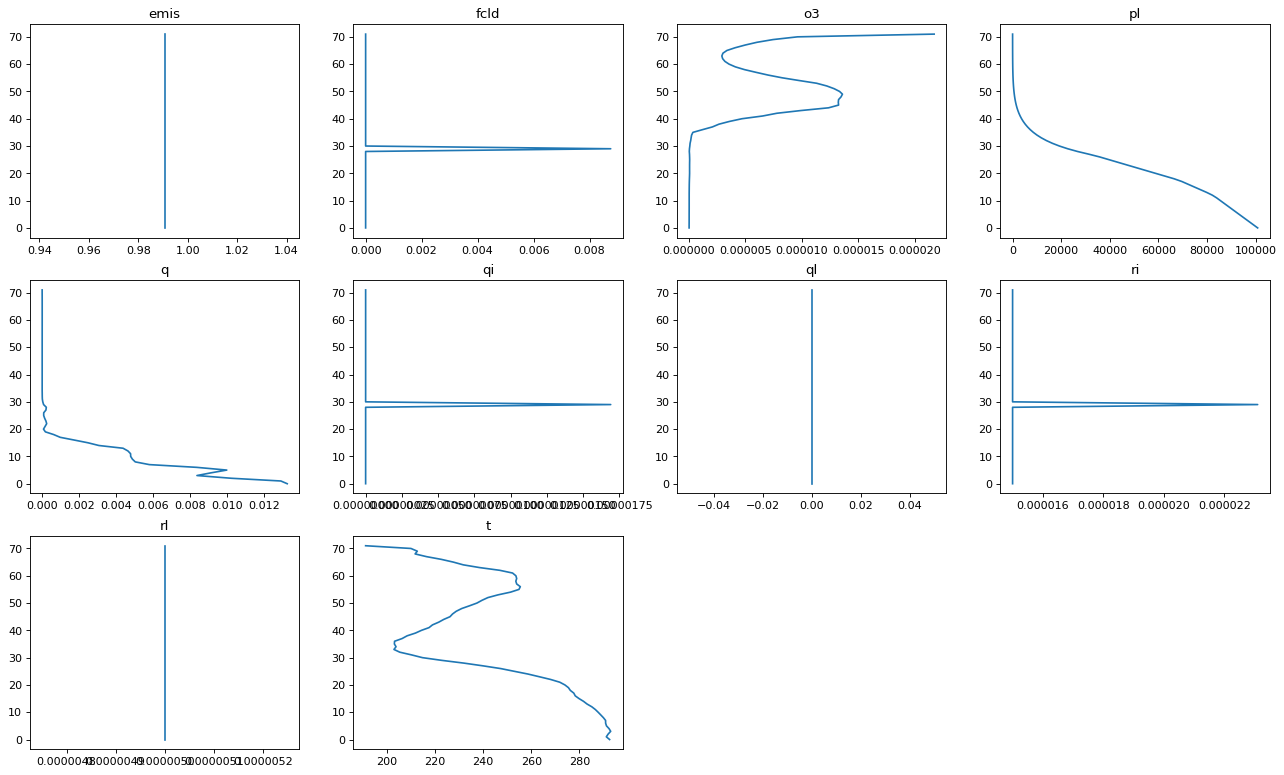

In [14]:
Plot_Batch(xmin, header_x)

In [41]:
Plot_Batch( np.concatenate( [y[[0]], y0[[0]]], axis=0), ['flx'])

ValueError: all the input arrays must have same number of dimensions

In [17]:
xmin0 = Produce_x_nc4(F, 1,1, header_x)

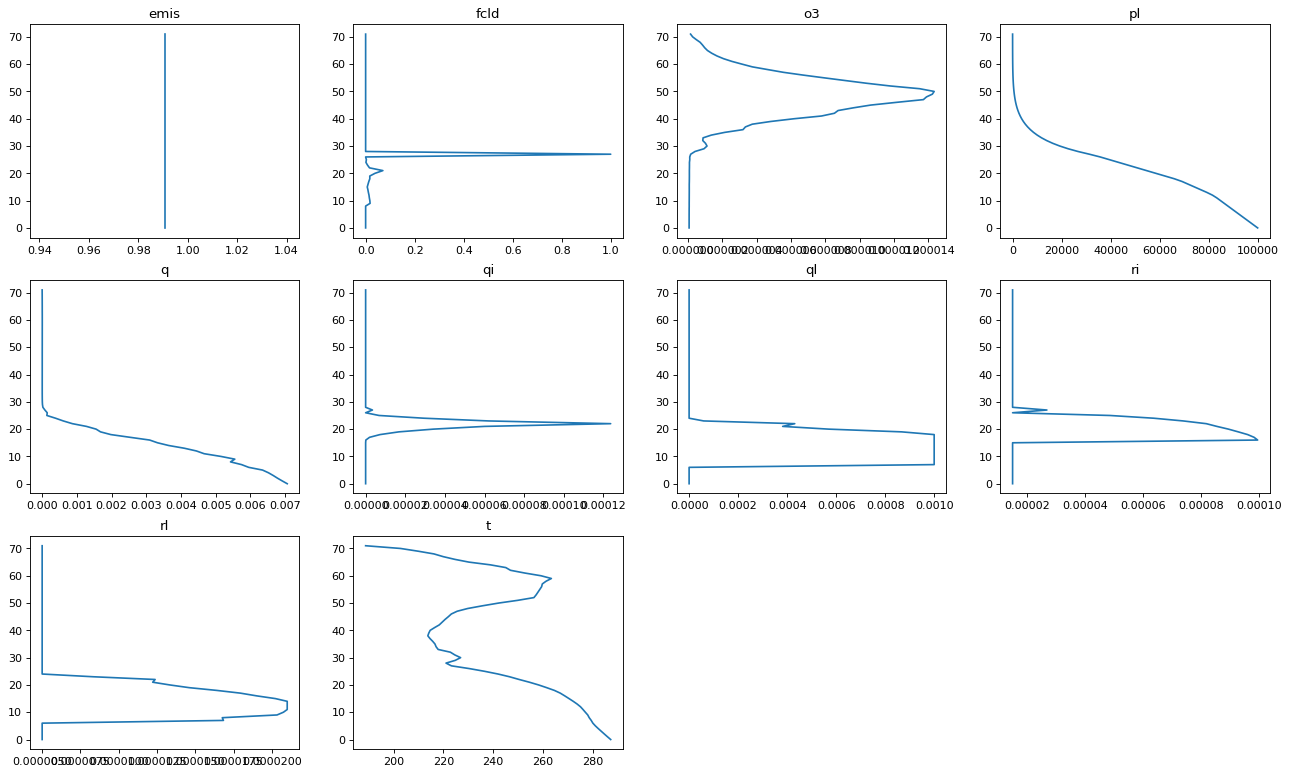

In [35]:
p_use=4
xmin = xnc4[[p_use]]
Plot_Batch(xmin, header_x)
plt.savefig(profile[p_use]+'_input'+'.jpg')

In [36]:
def Jacobian_Fortran(Mlist,x, dt):
    """
    Compute the Jacobian of x
    x has shape (1, lev, n_var)
    M product an output of size (1, lev)
    """
    _, lev, n_var= x.shape
    Jac = np.zeros((n_var, lev, lev))
    P0 = medium_pred(Mlist, x)
    P1 = P0.copy()*0
    # could be more optimize [l steps instead of l*n_var]
    # Using one pred of size lev*n_var produce odd result, lev*header_x pred
    # which is not optimal

    for v in range(n_var):
        for l in range(lev):
            x0 = x.copy()
            pert = x[0,l,v]/dt
            x0[0, l, v] += pert
            P1 = medium_pred(Mlist, x0)
            if abs(pert)>0:
                Jac[v, l, :] = (P1-P0)/pert
    return Jac

def Jacobian_Single_Var_emis(Mlist,x, v_id, dt):
    """
    Compute the jacobian for 1 value vars such as emis 
    v_id, id of the variable in the header_x (header.index(variable))
    """
    _, lev, n_var= x.shape
    J = np.zeros((lev))    
    x0 = x.copy()
    x0[0,:,v_id]+=x0[0,0,0]/dt
    P1 = medium_pred(Mlist ,x)
    P2 = medium_pred(Mlist, x0)
    return (P1-P2)



a,b = Profile_to_Generator(train_generator, 720, 31)

J = Jacobian_Fortran([M, M1], xmin, 1000)
J1 = Jacobian_Fortran([M1], xmin, 1000)
J0 = Jacobian_Fortran([M], xmin, 1000)
J_emis =  Jacobian_Single_Var_emis([M, M1], xmin, header_x.index('emis'), 1000)
#J_emis_0 =  Jacobian_Single_Var_emis(M, xmin, header_x.index('emis'), 1000)

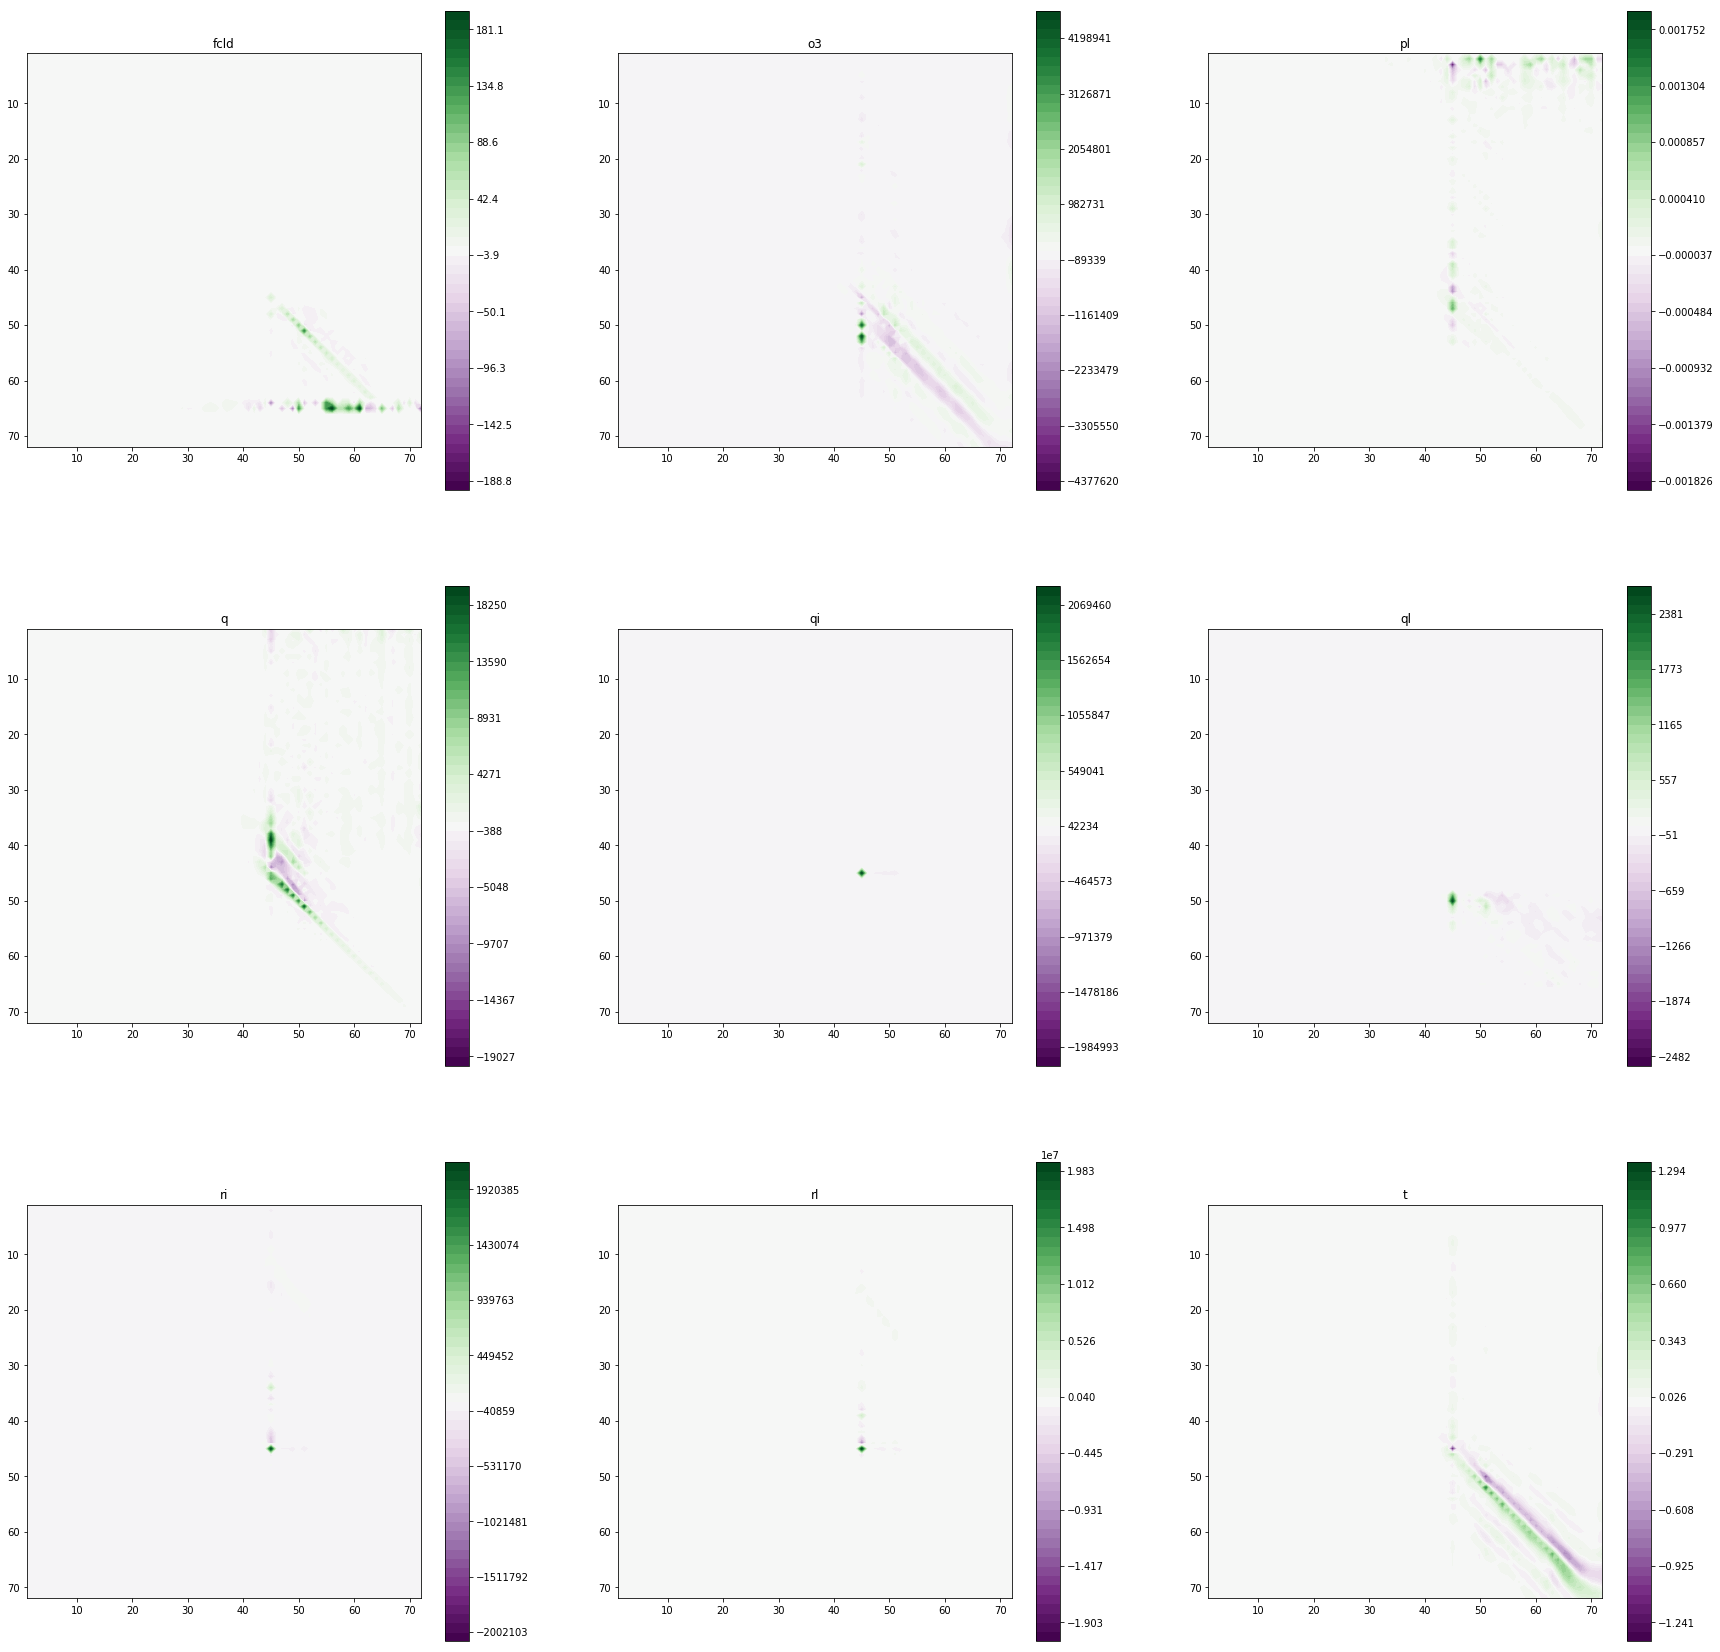

In [37]:
from utils import Sep_Var_show

def Sep_Var_show(F,J, header_x, T=True):
    """
    Show the Jacobian of each variable
    F : F and Plot class element of len len(header_x)
    header_x : list of variables
    J gradient of size (lev, n_var*lev)
    """
    c, l, _ = J.shape
    n_var = len(header_x)
    lev = l
    z = np.arange(1,73,1)
    for j in range(len(header_x)):
        if j>0:
            IMG = J[j]
            maxf = np.max(np.abs(IMG)) 
            if maxf == 0:
                maxf = 1.0
            incf = 2*maxf/51.
            clevs = np.arange(-maxf,maxf+incf,incf)
            im = F[j-1].contourf(z,z, IMG, clevs, cmap='PRGn')
            F[j-1].set_title(header_x[j])
            F[j-1].set_aspect('equal','box')
            F[j-1].invert_yaxis()
            F.f.colorbar(im, ax=F[j-1])

F=F_and_plots(figsize=(30,30), shape=(3,3))
F.f.savefig(profile[p_use]+'_jacob_mean'+'.jpg')
Sep_Var_show(F,J, header_x)

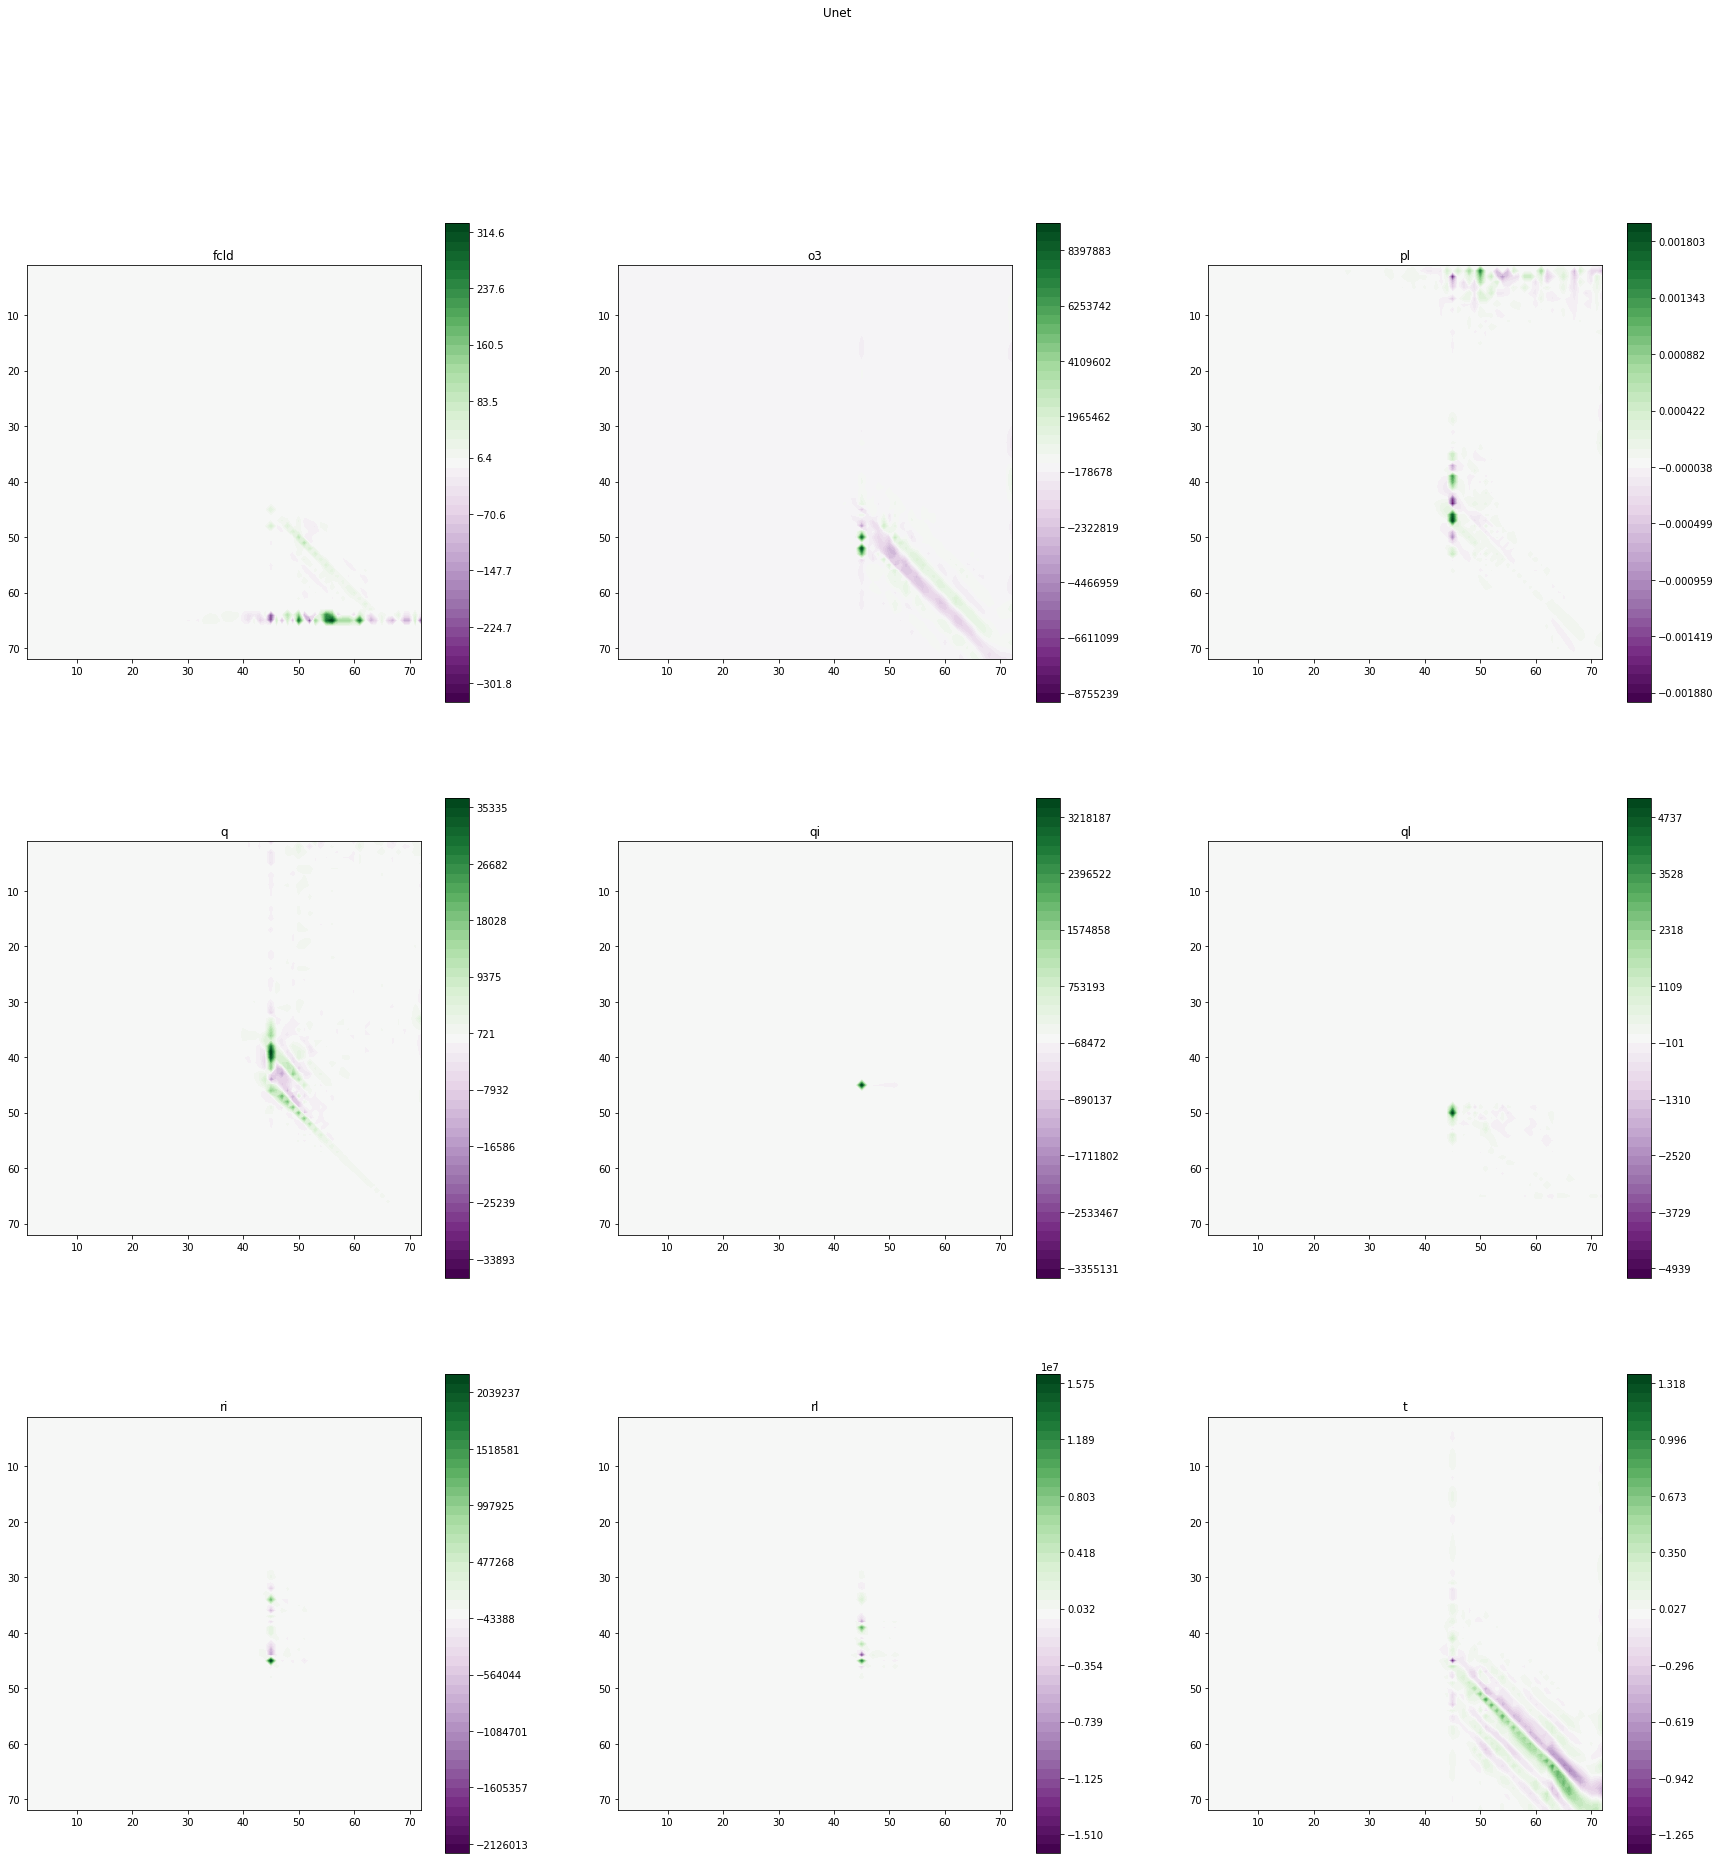

In [38]:
F=F_and_plots(figsize=(30,30), shape=(3,3))
Sep_Var_show(F,J0, header_x)
F.f.suptitle("Unet");
F.f.savefig(profile[p_use]+'_jacob_unet'+'.jpg')

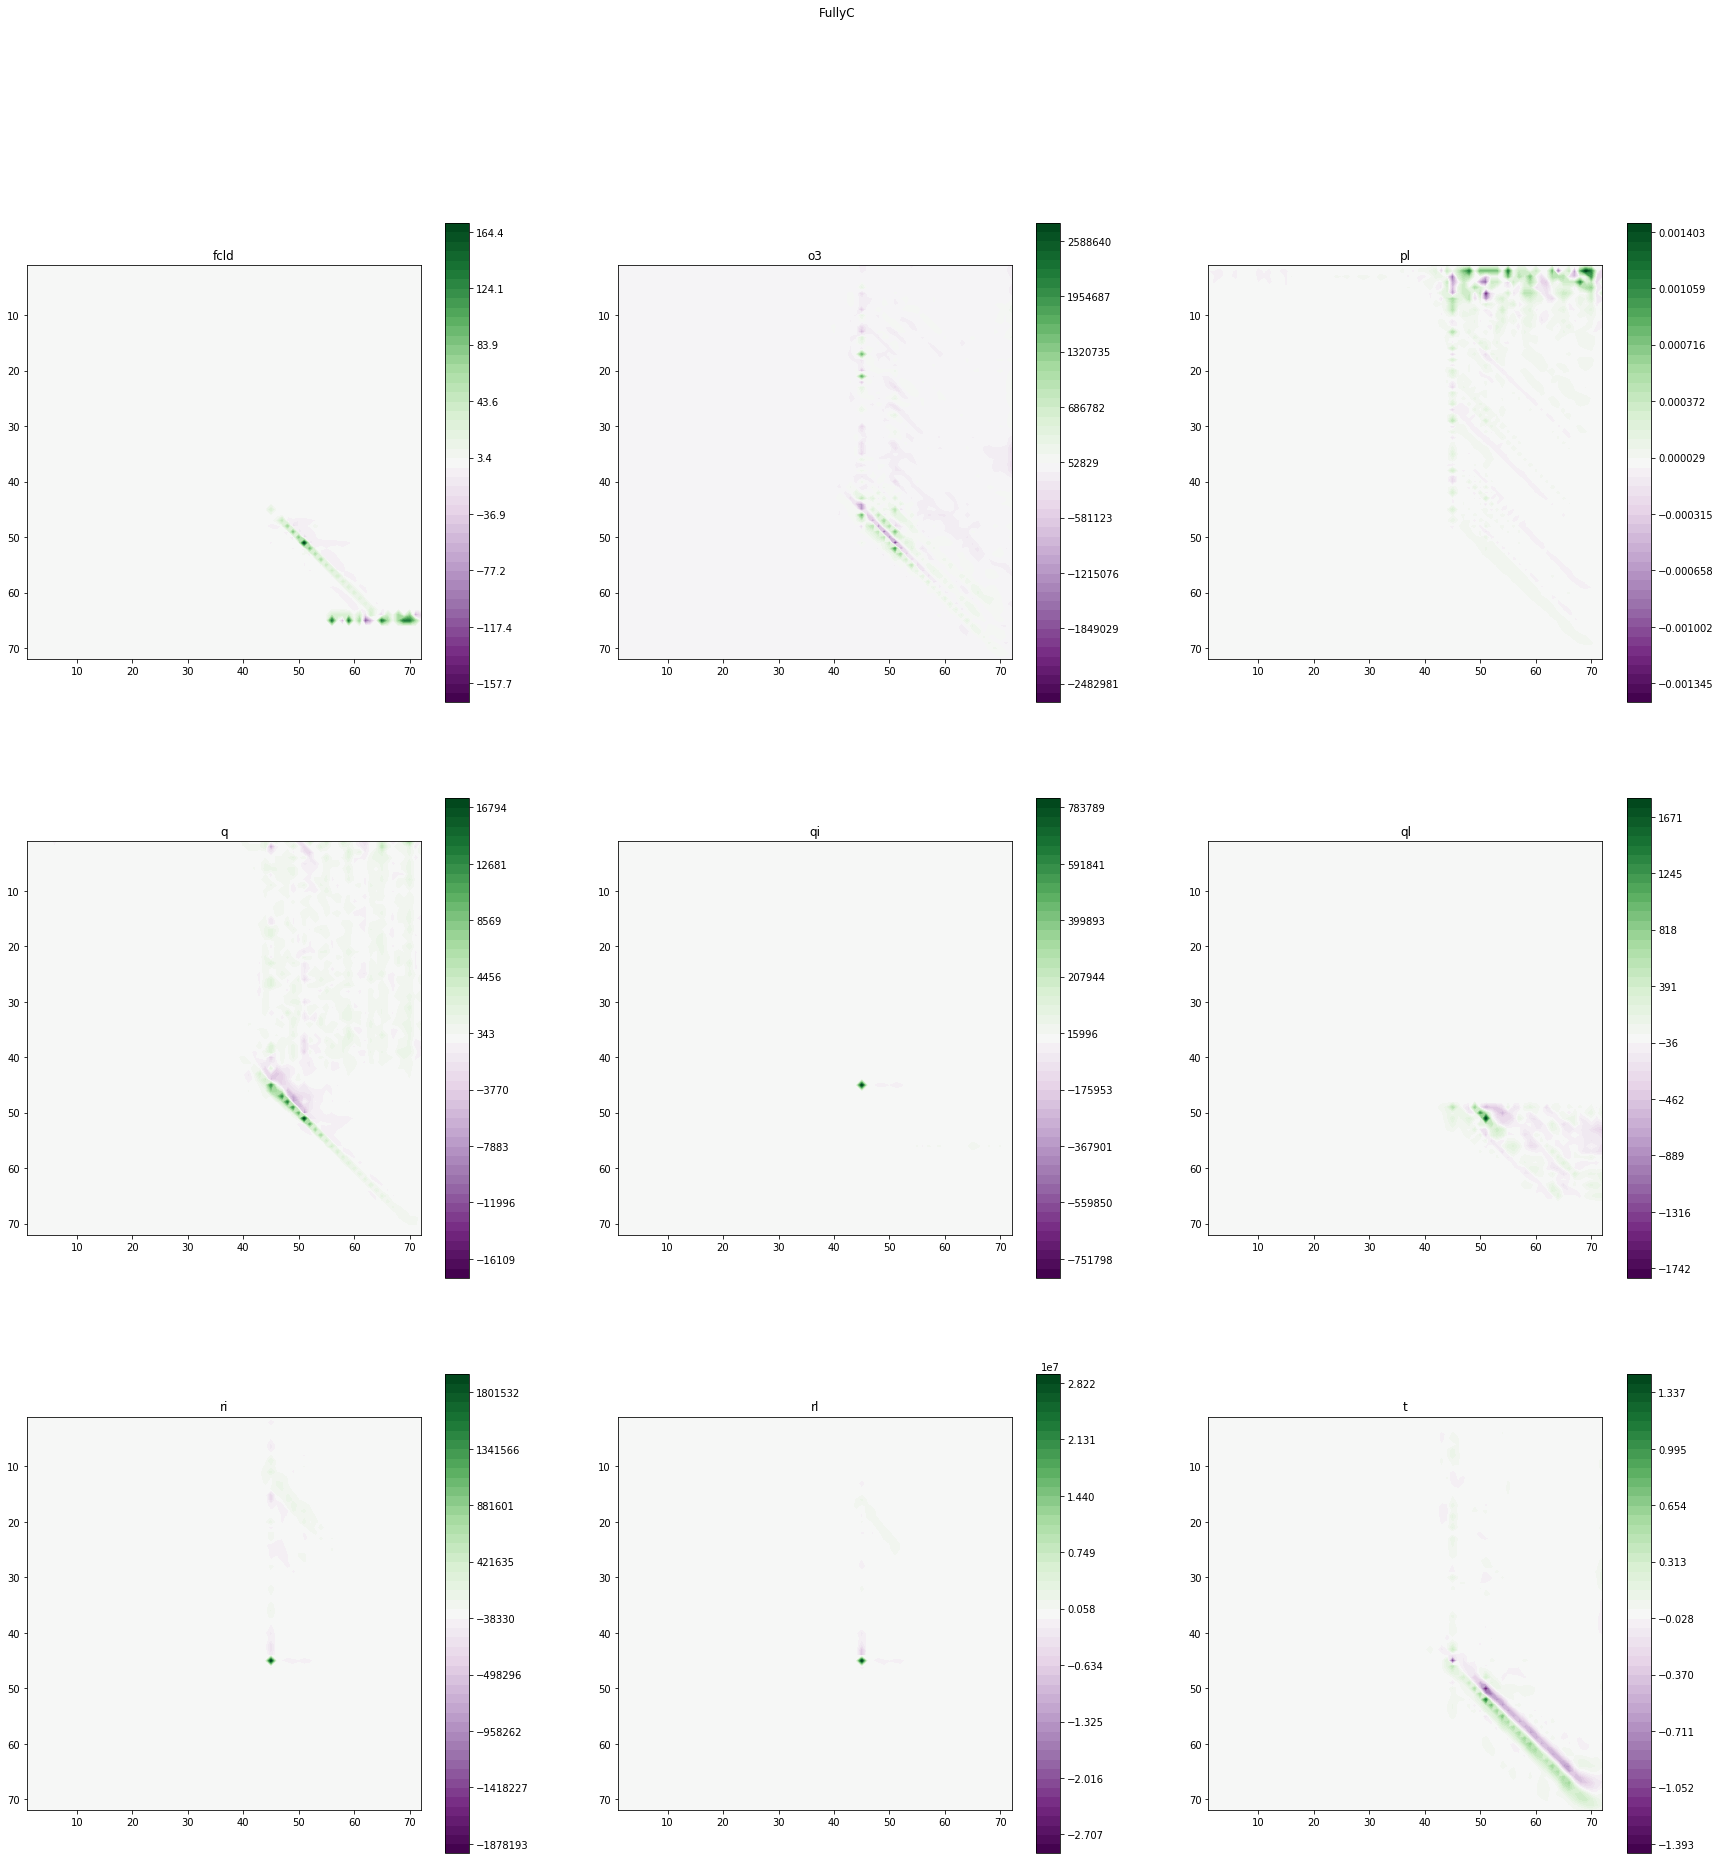

In [39]:
F=F_and_plots(figsize=(30,30), shape=(3,3))
F.f.suptitle('FullyC')
Sep_Var_show(F,J1, header_x)
F.f.savefig(profile[p_use]+'_jacob_fullyC'+'.jpg')

In [40]:
profiles

['jacobian_i0001_j0001',
 'jacobian_i0720_j1000',
 'jacobian_i0002_j0002',
 'jacobian_i0720_j0100',
 'jacobian_i0720_j0500',
 'jacobian_i0001_j0010']

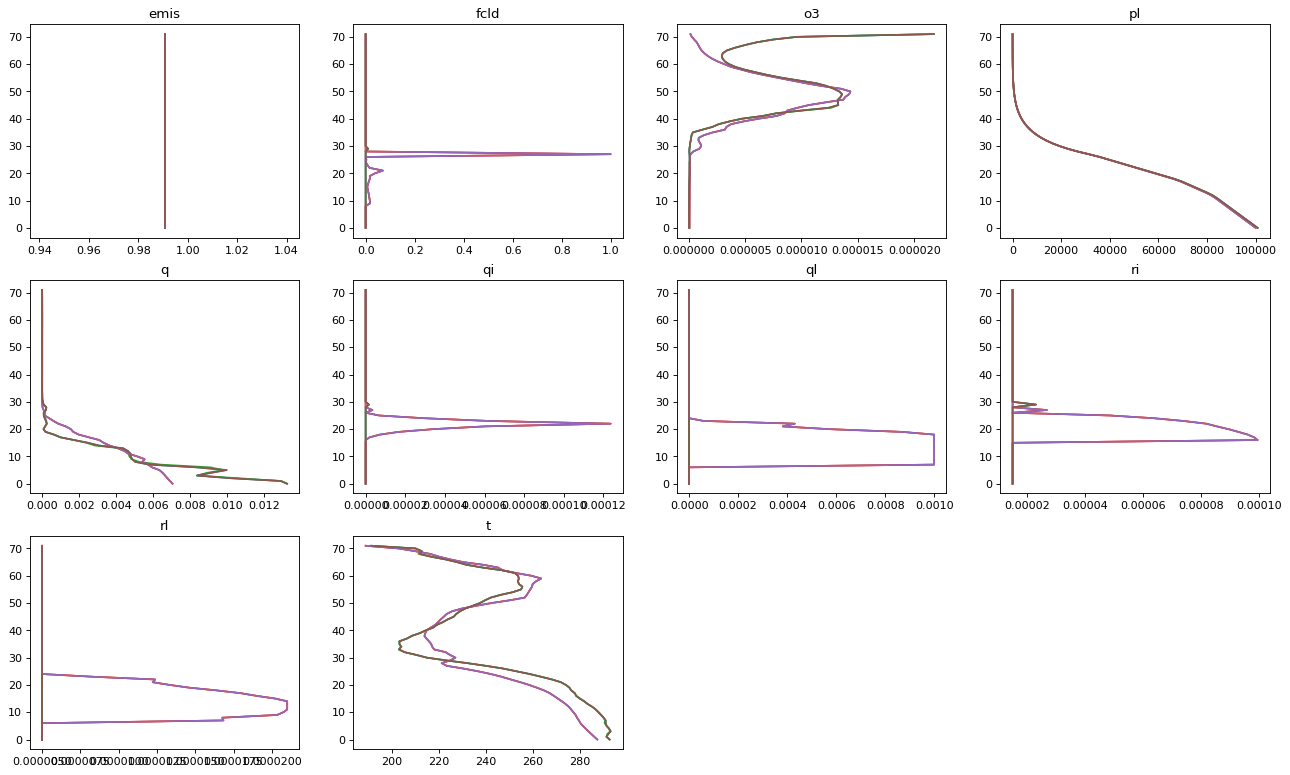

In [151]:
Plot_Batch(xnc4, header_x)

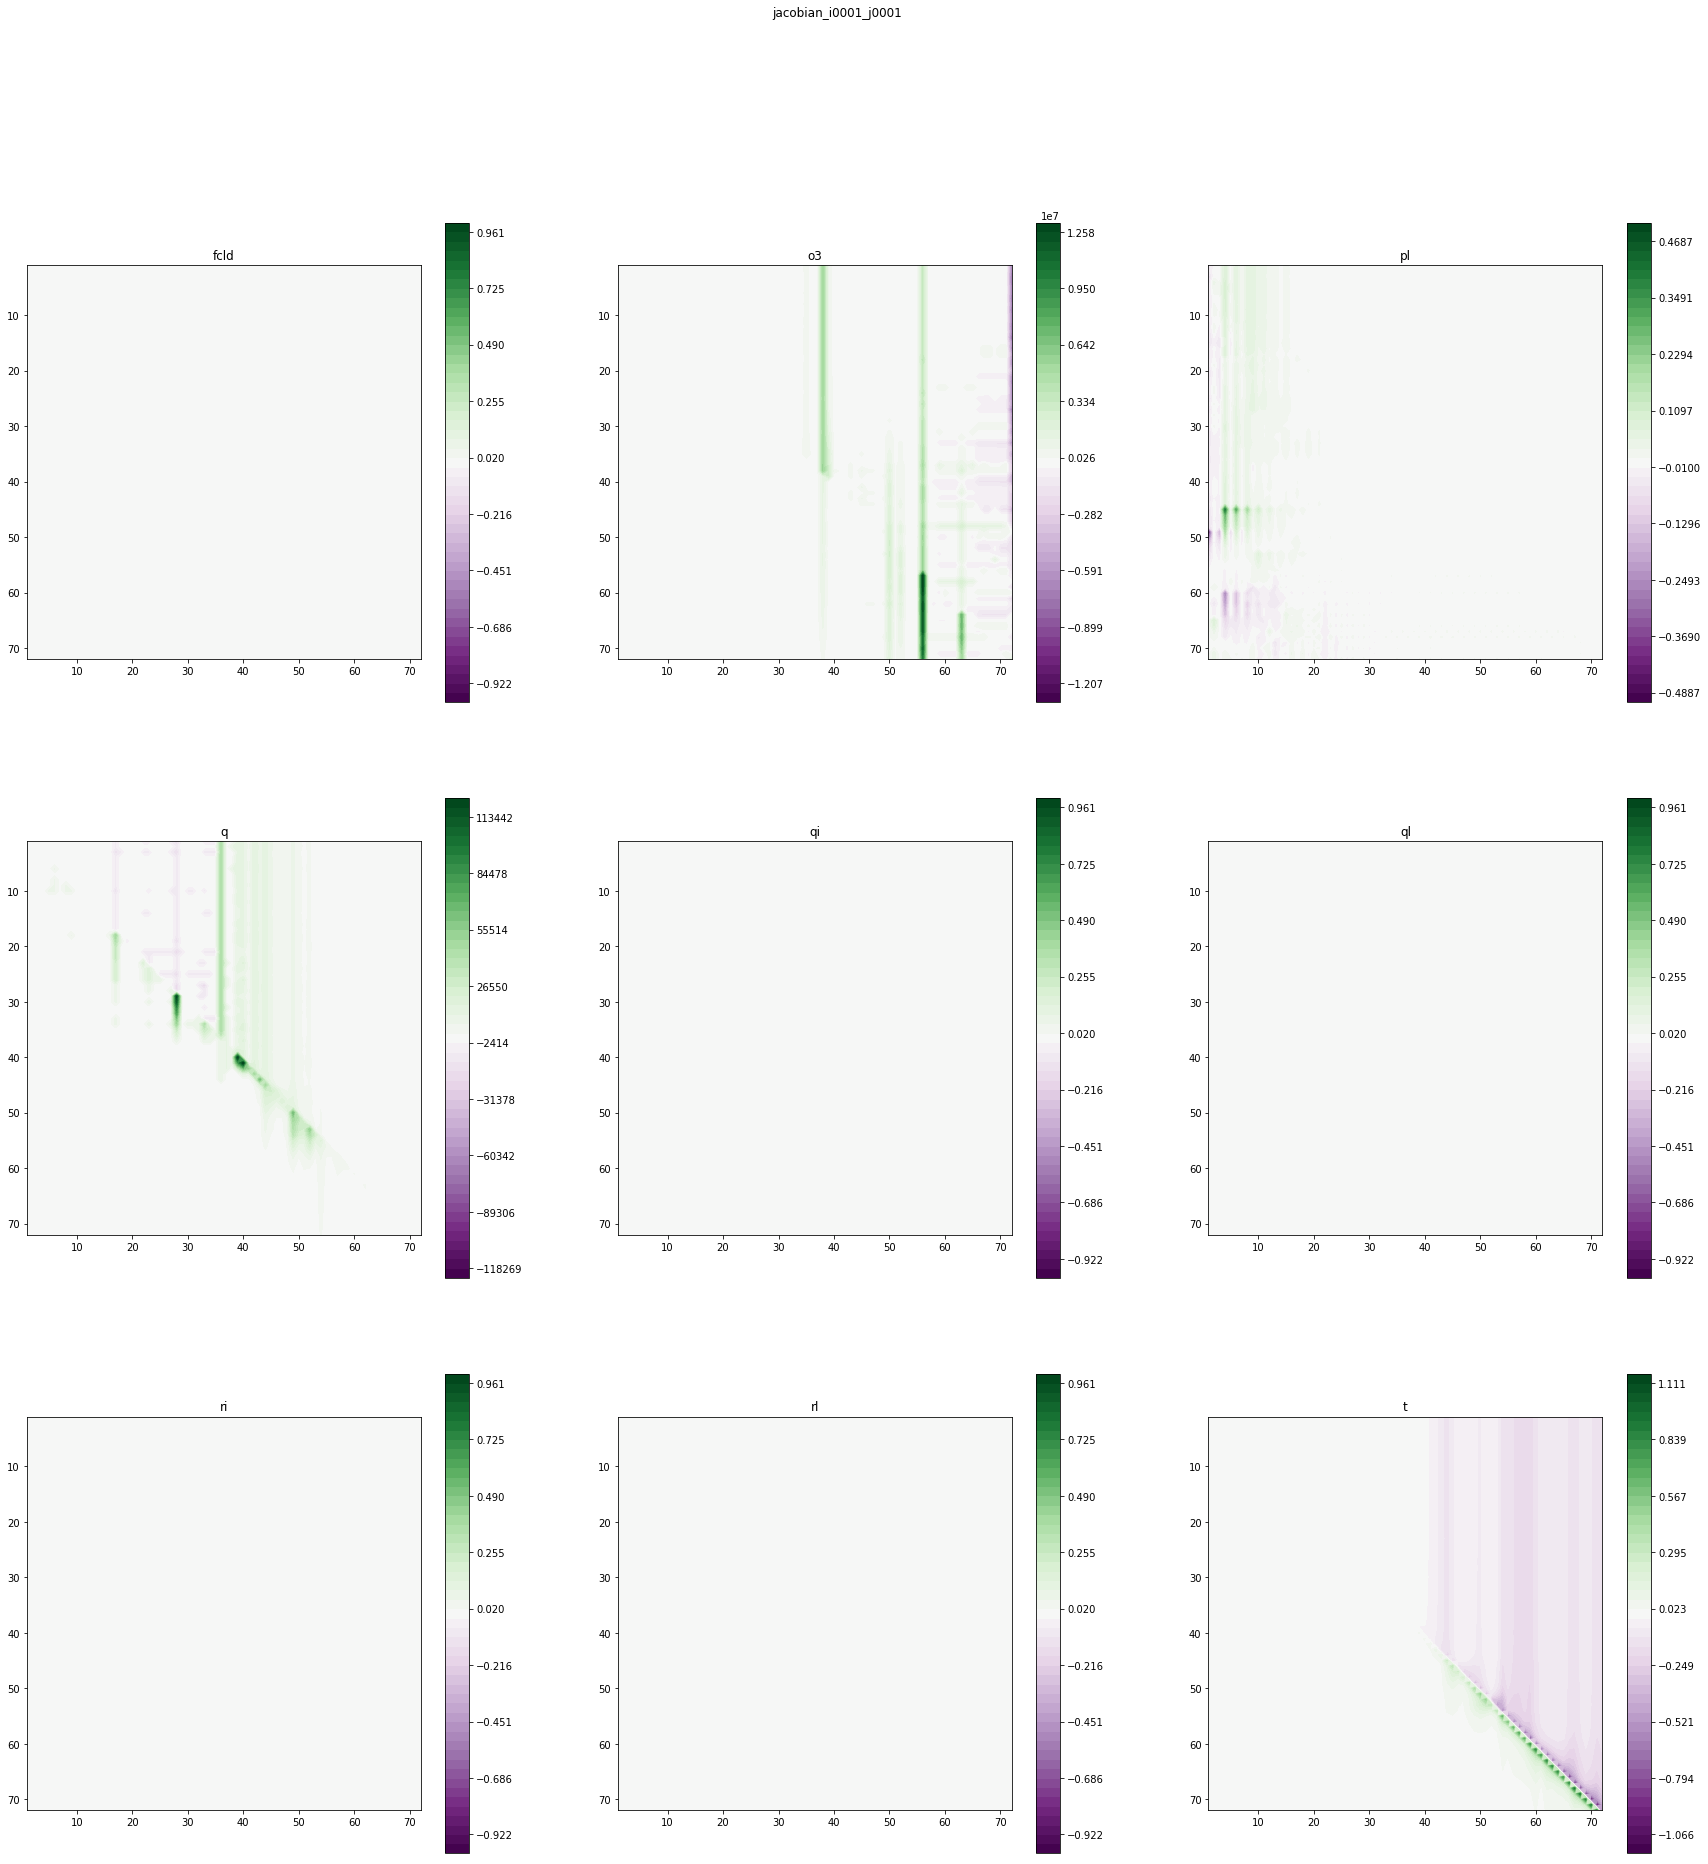

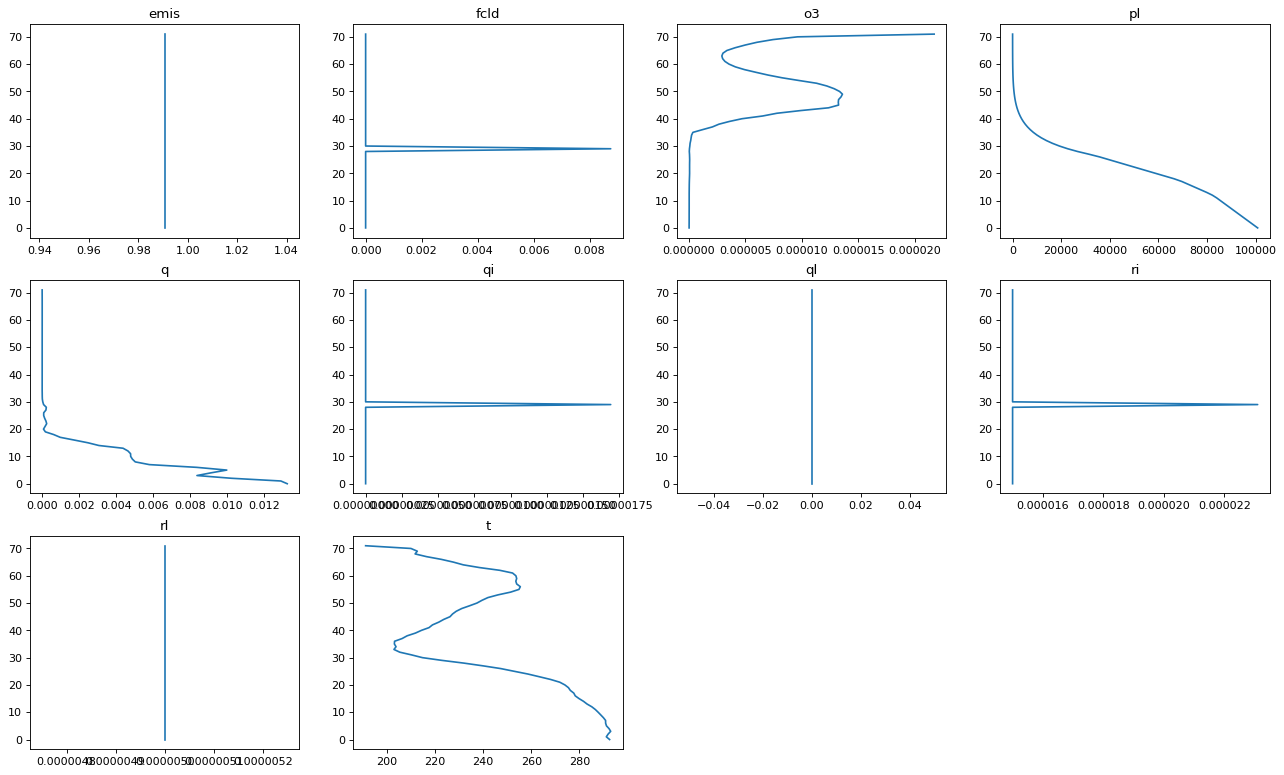

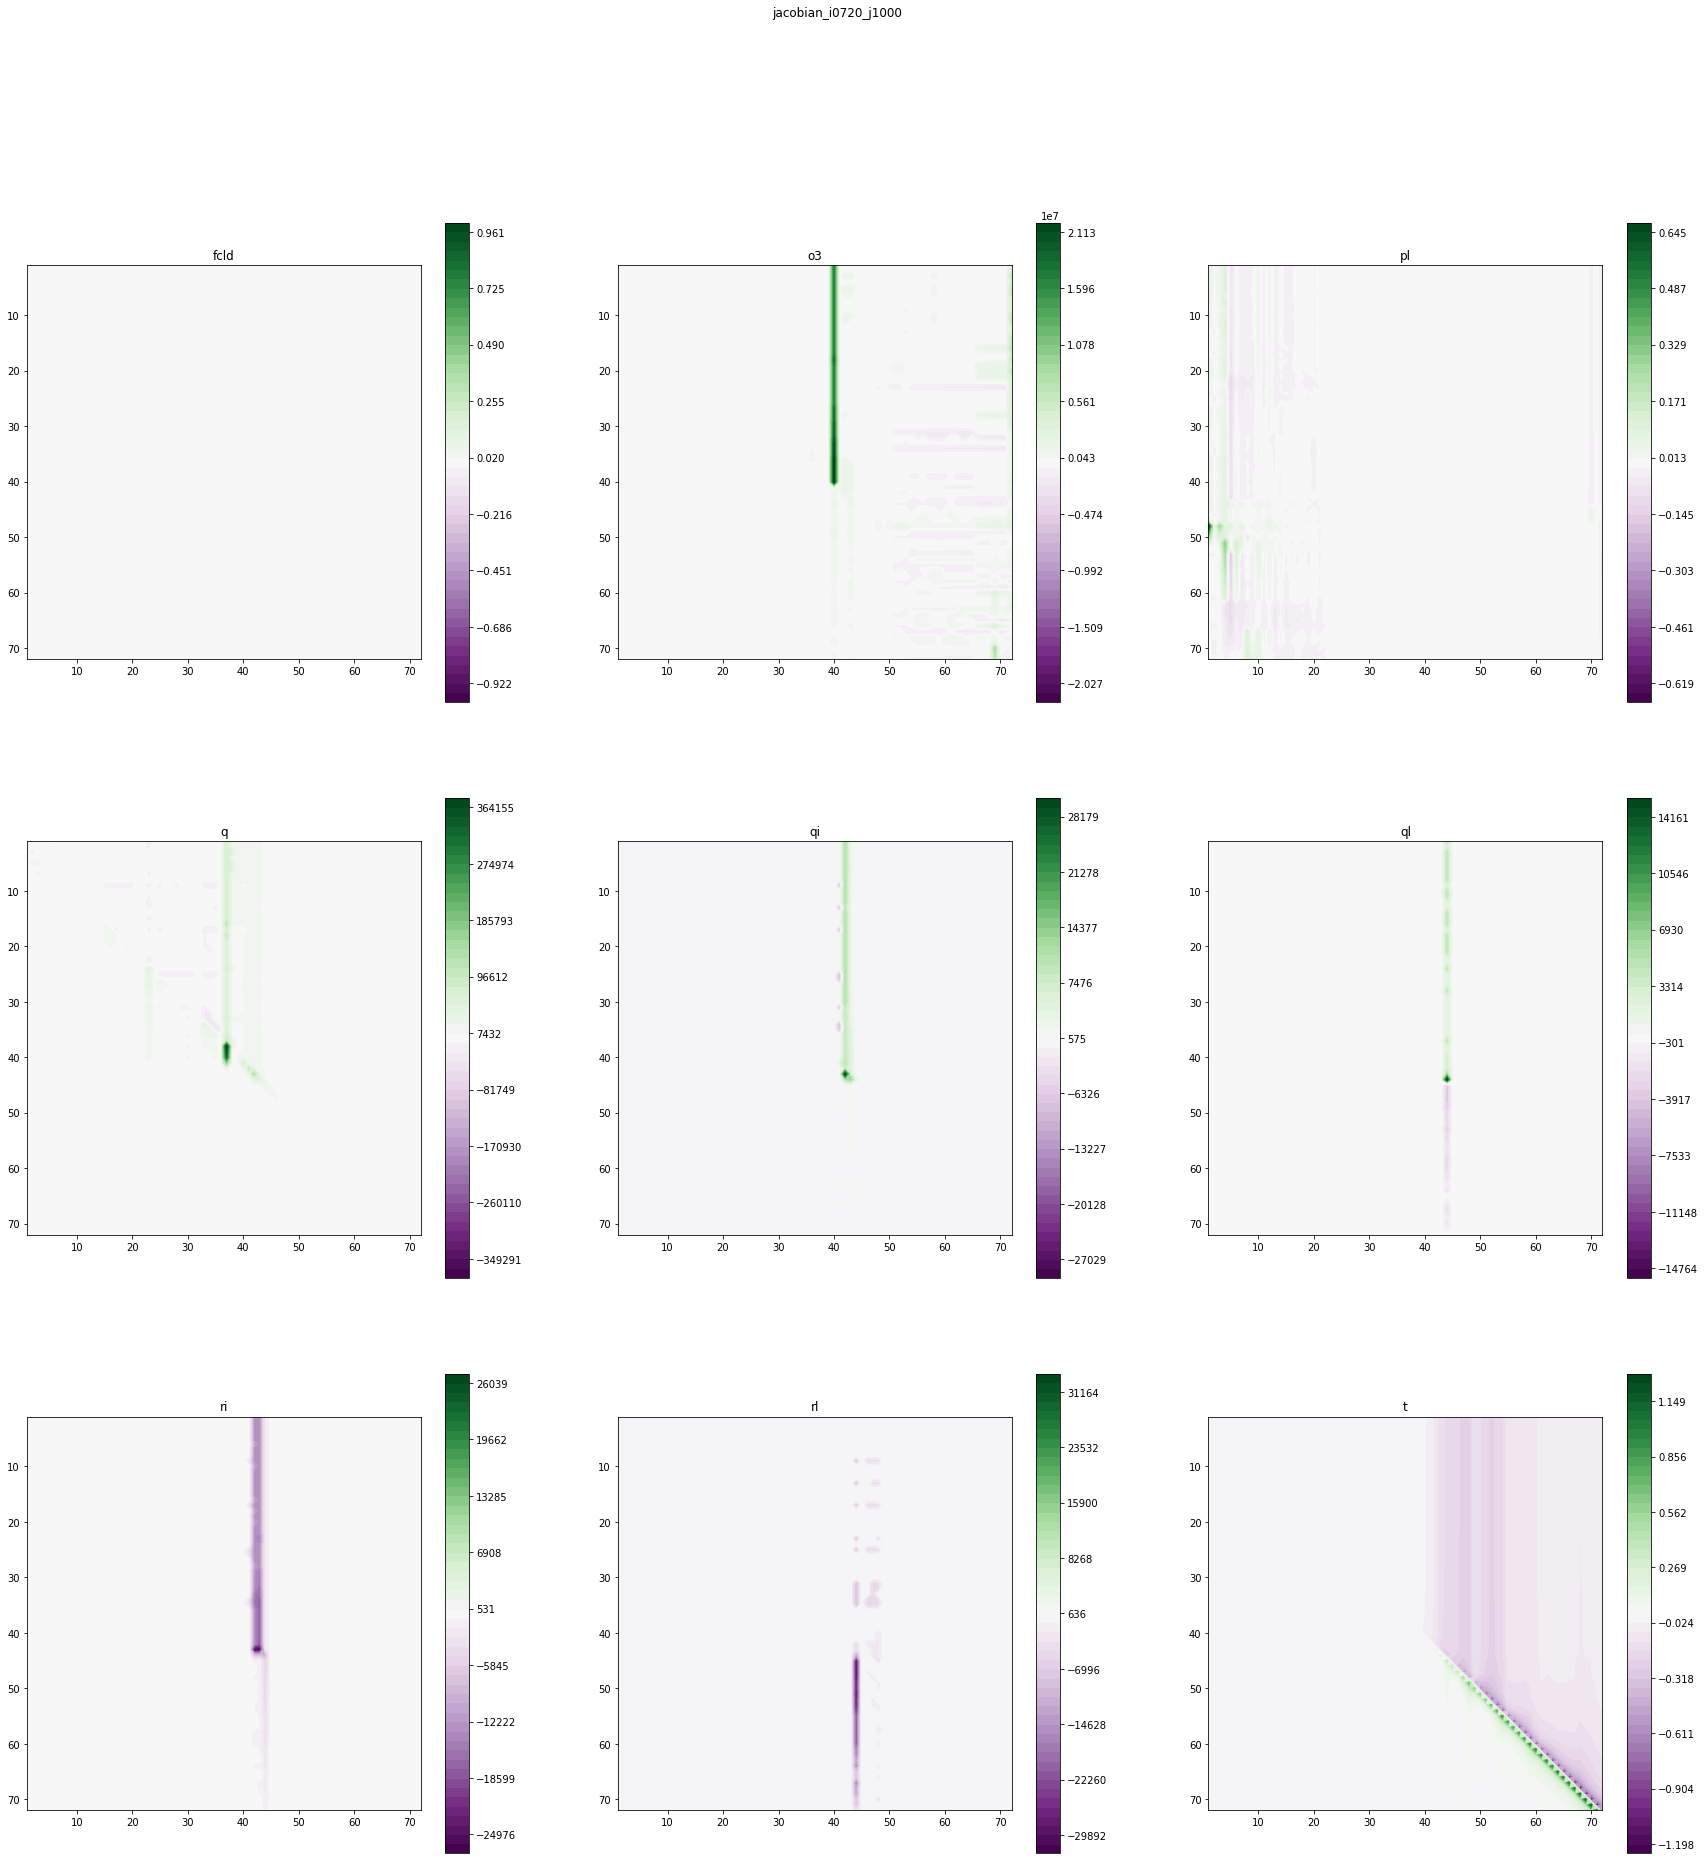

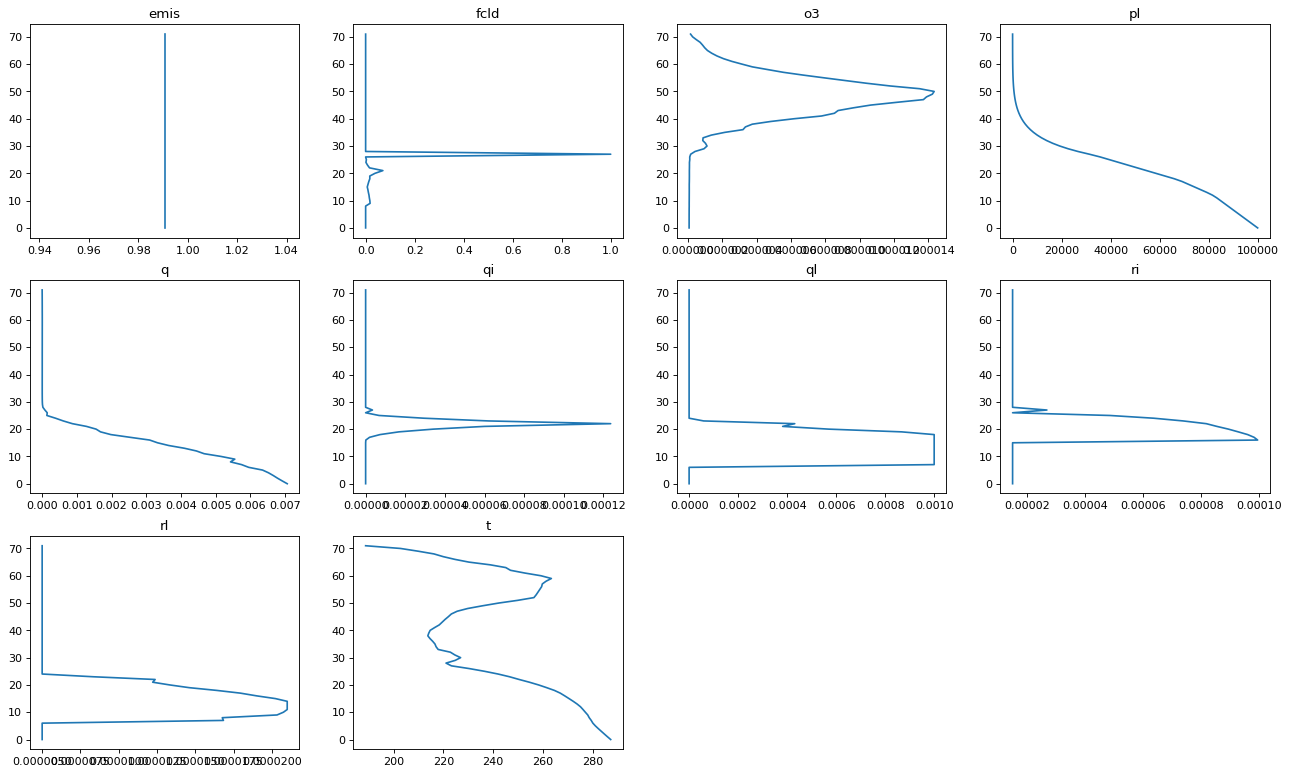

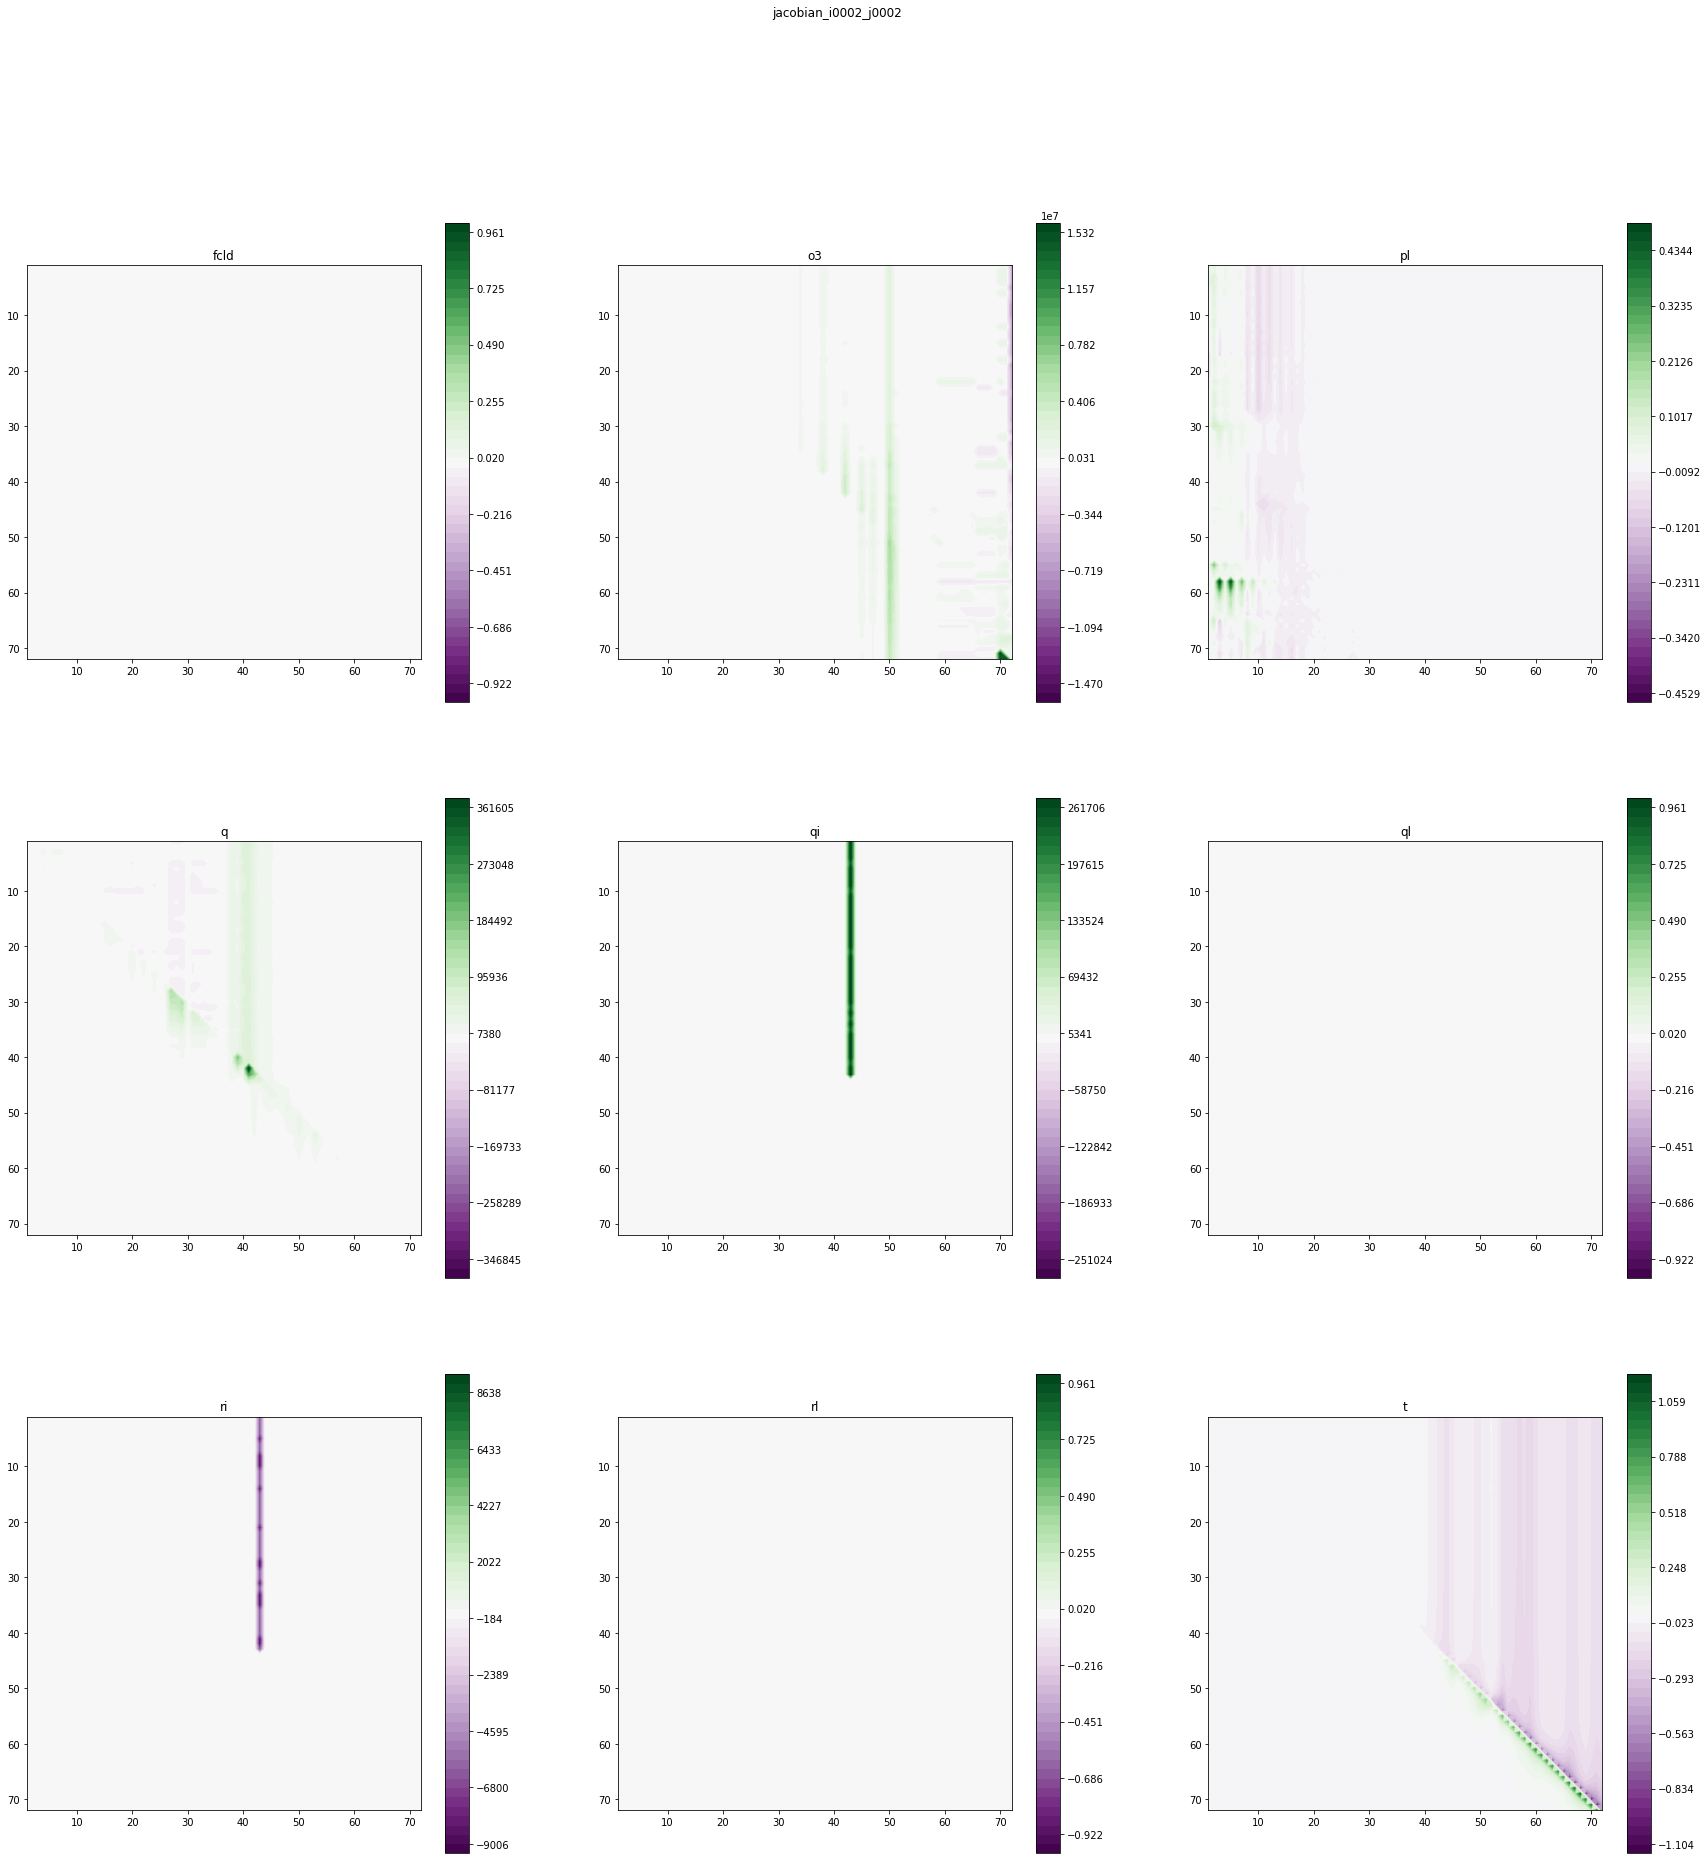

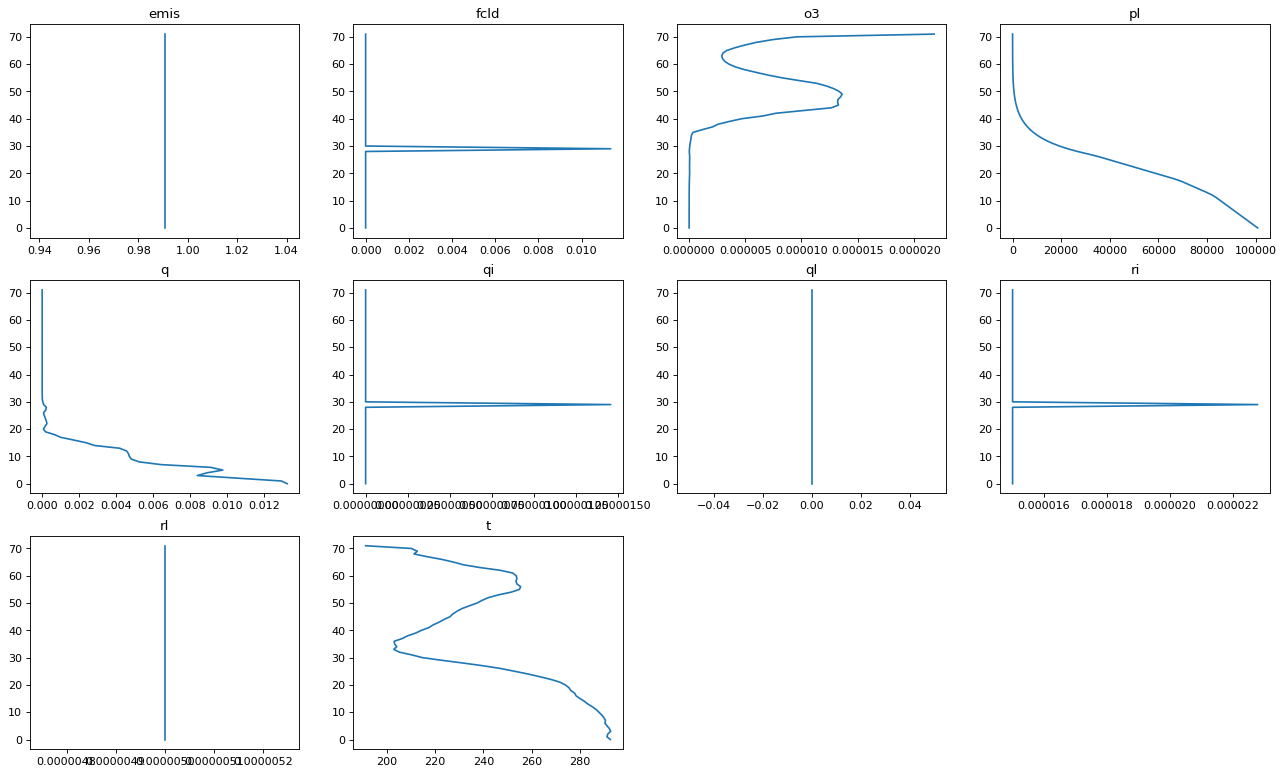

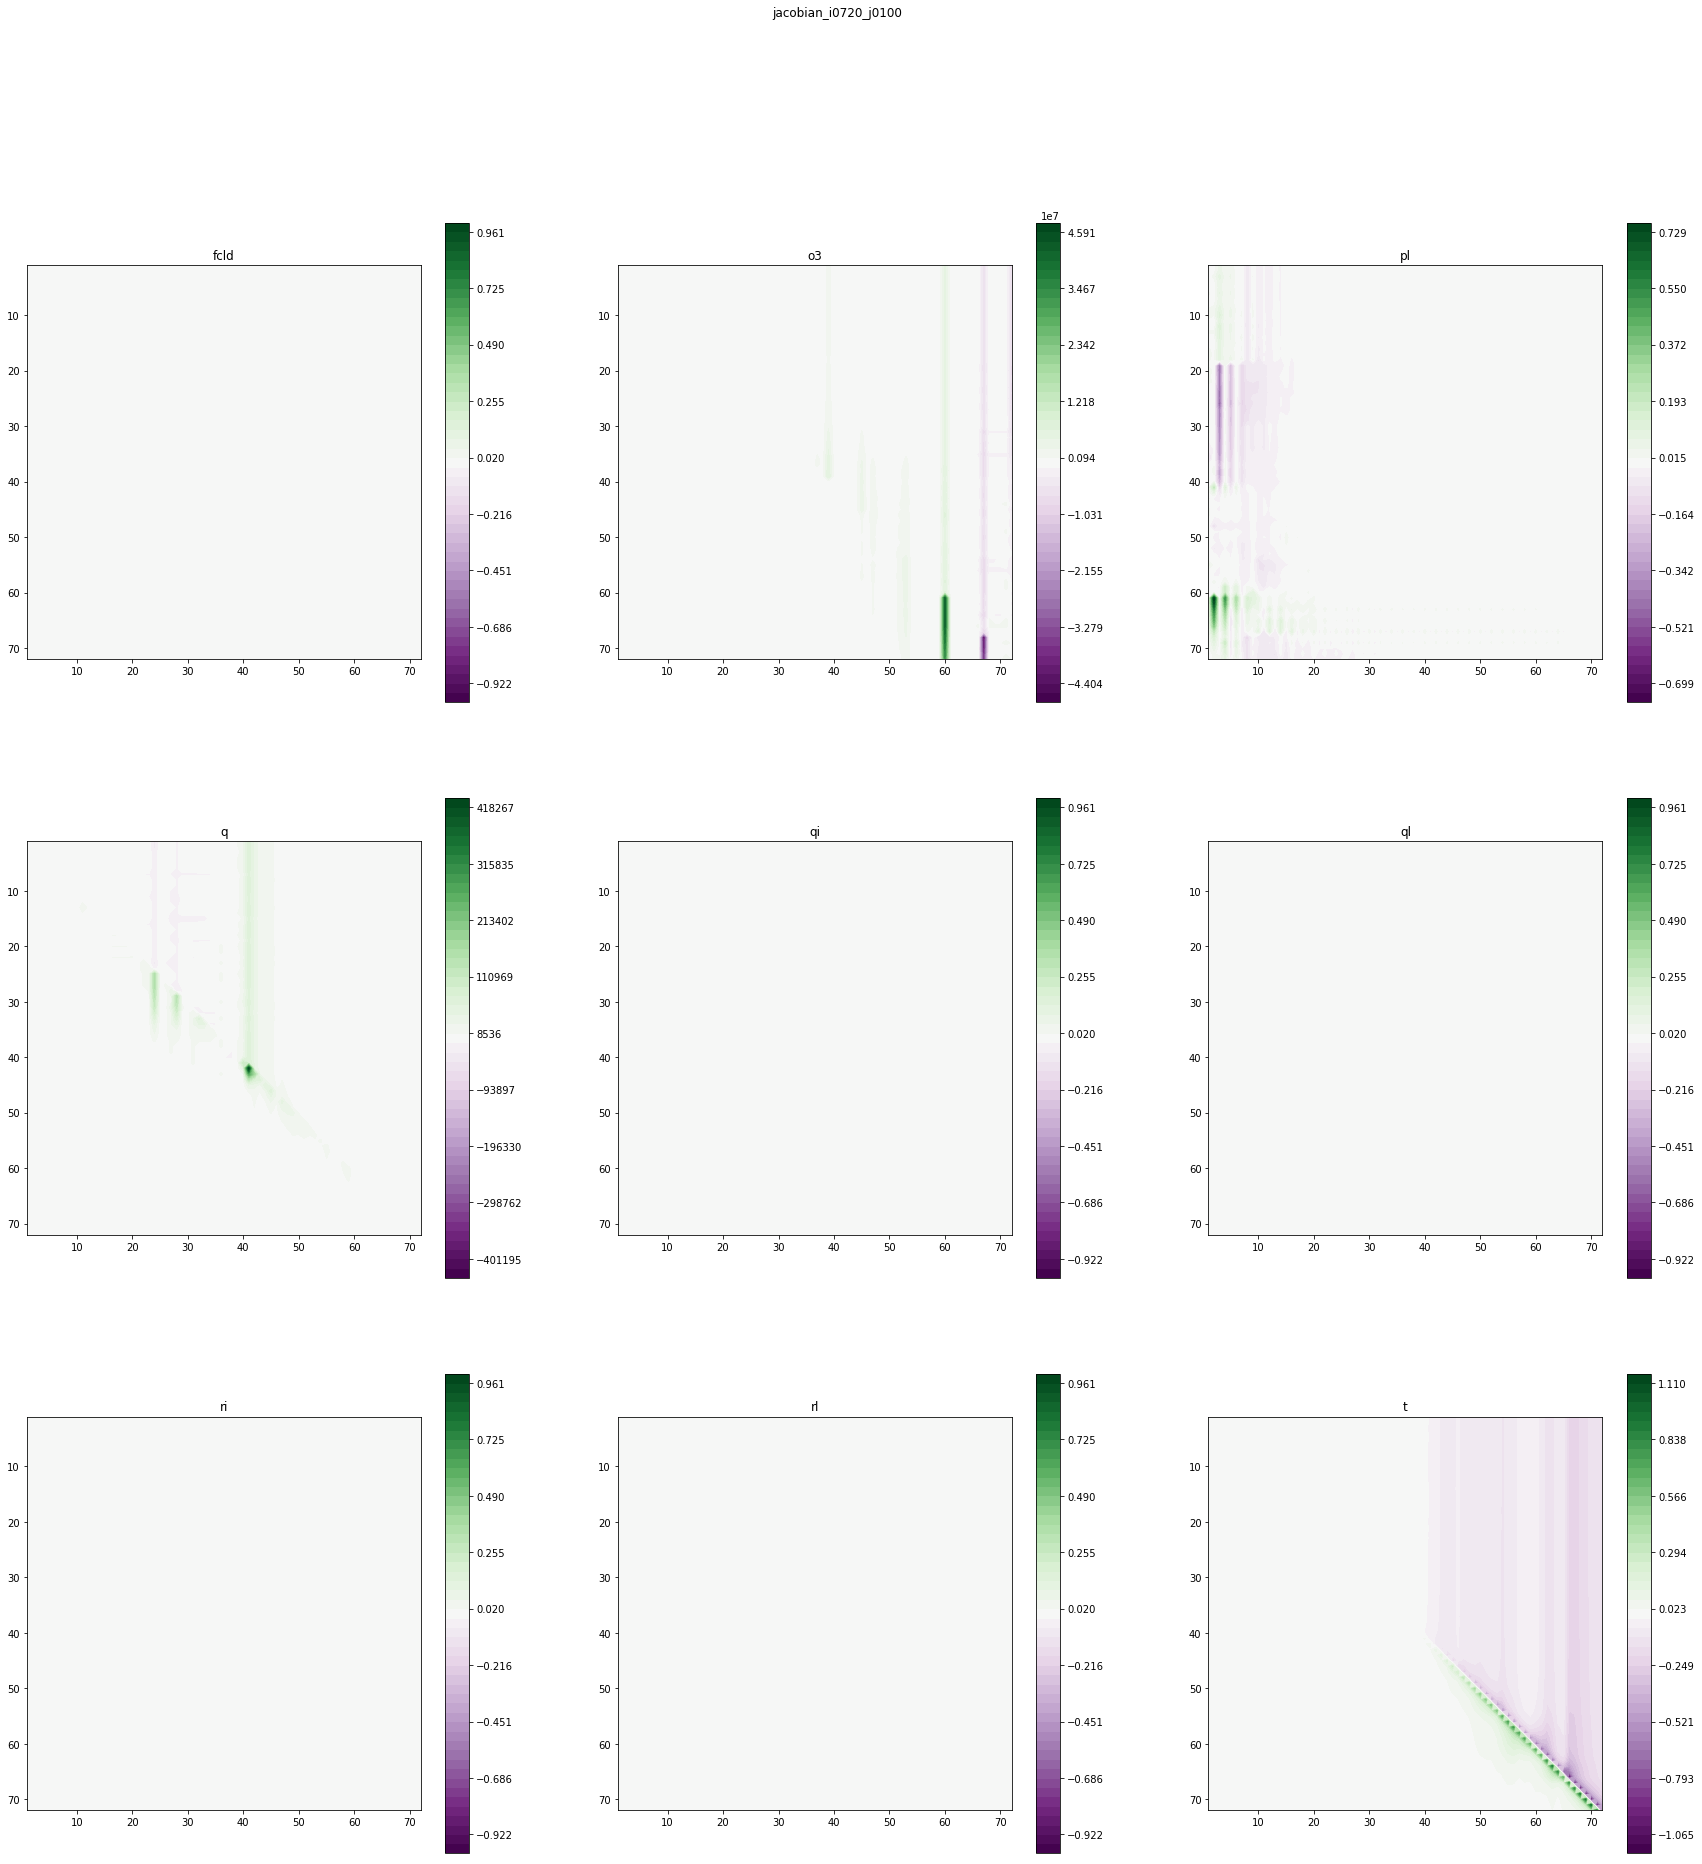

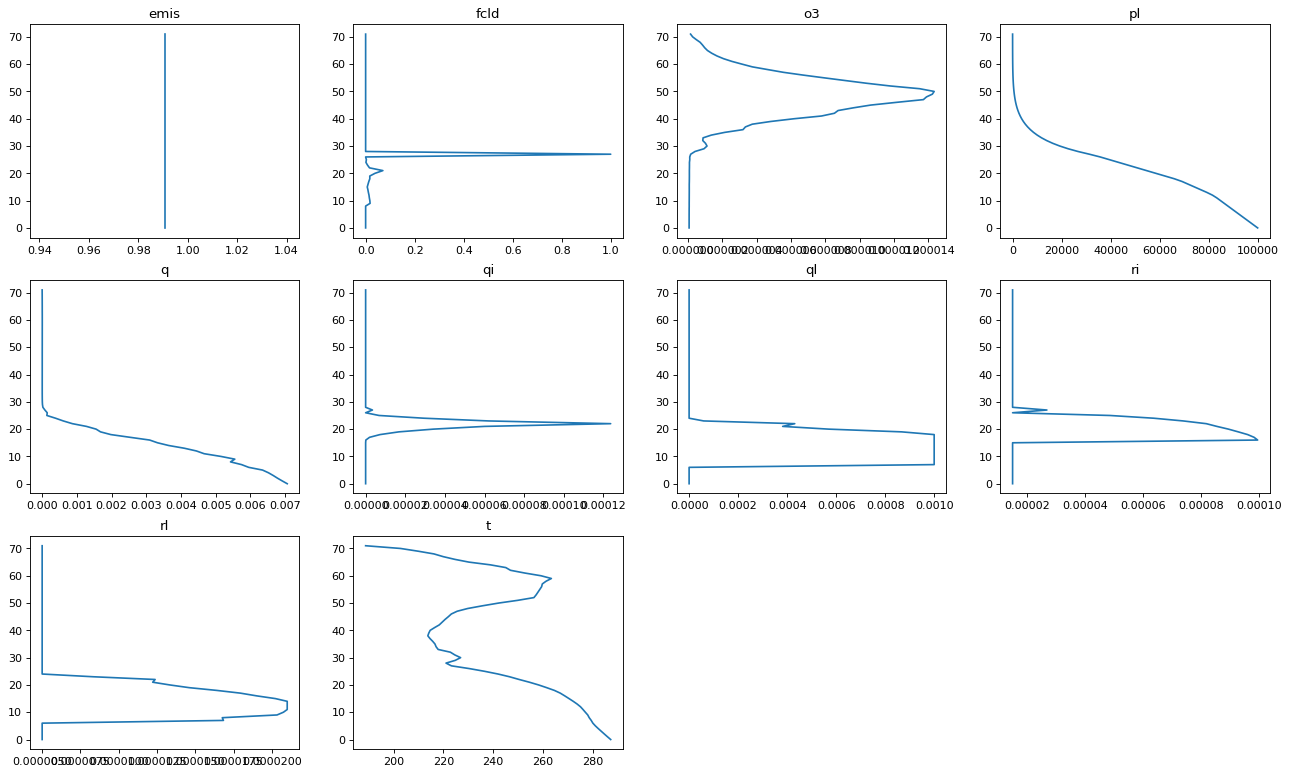

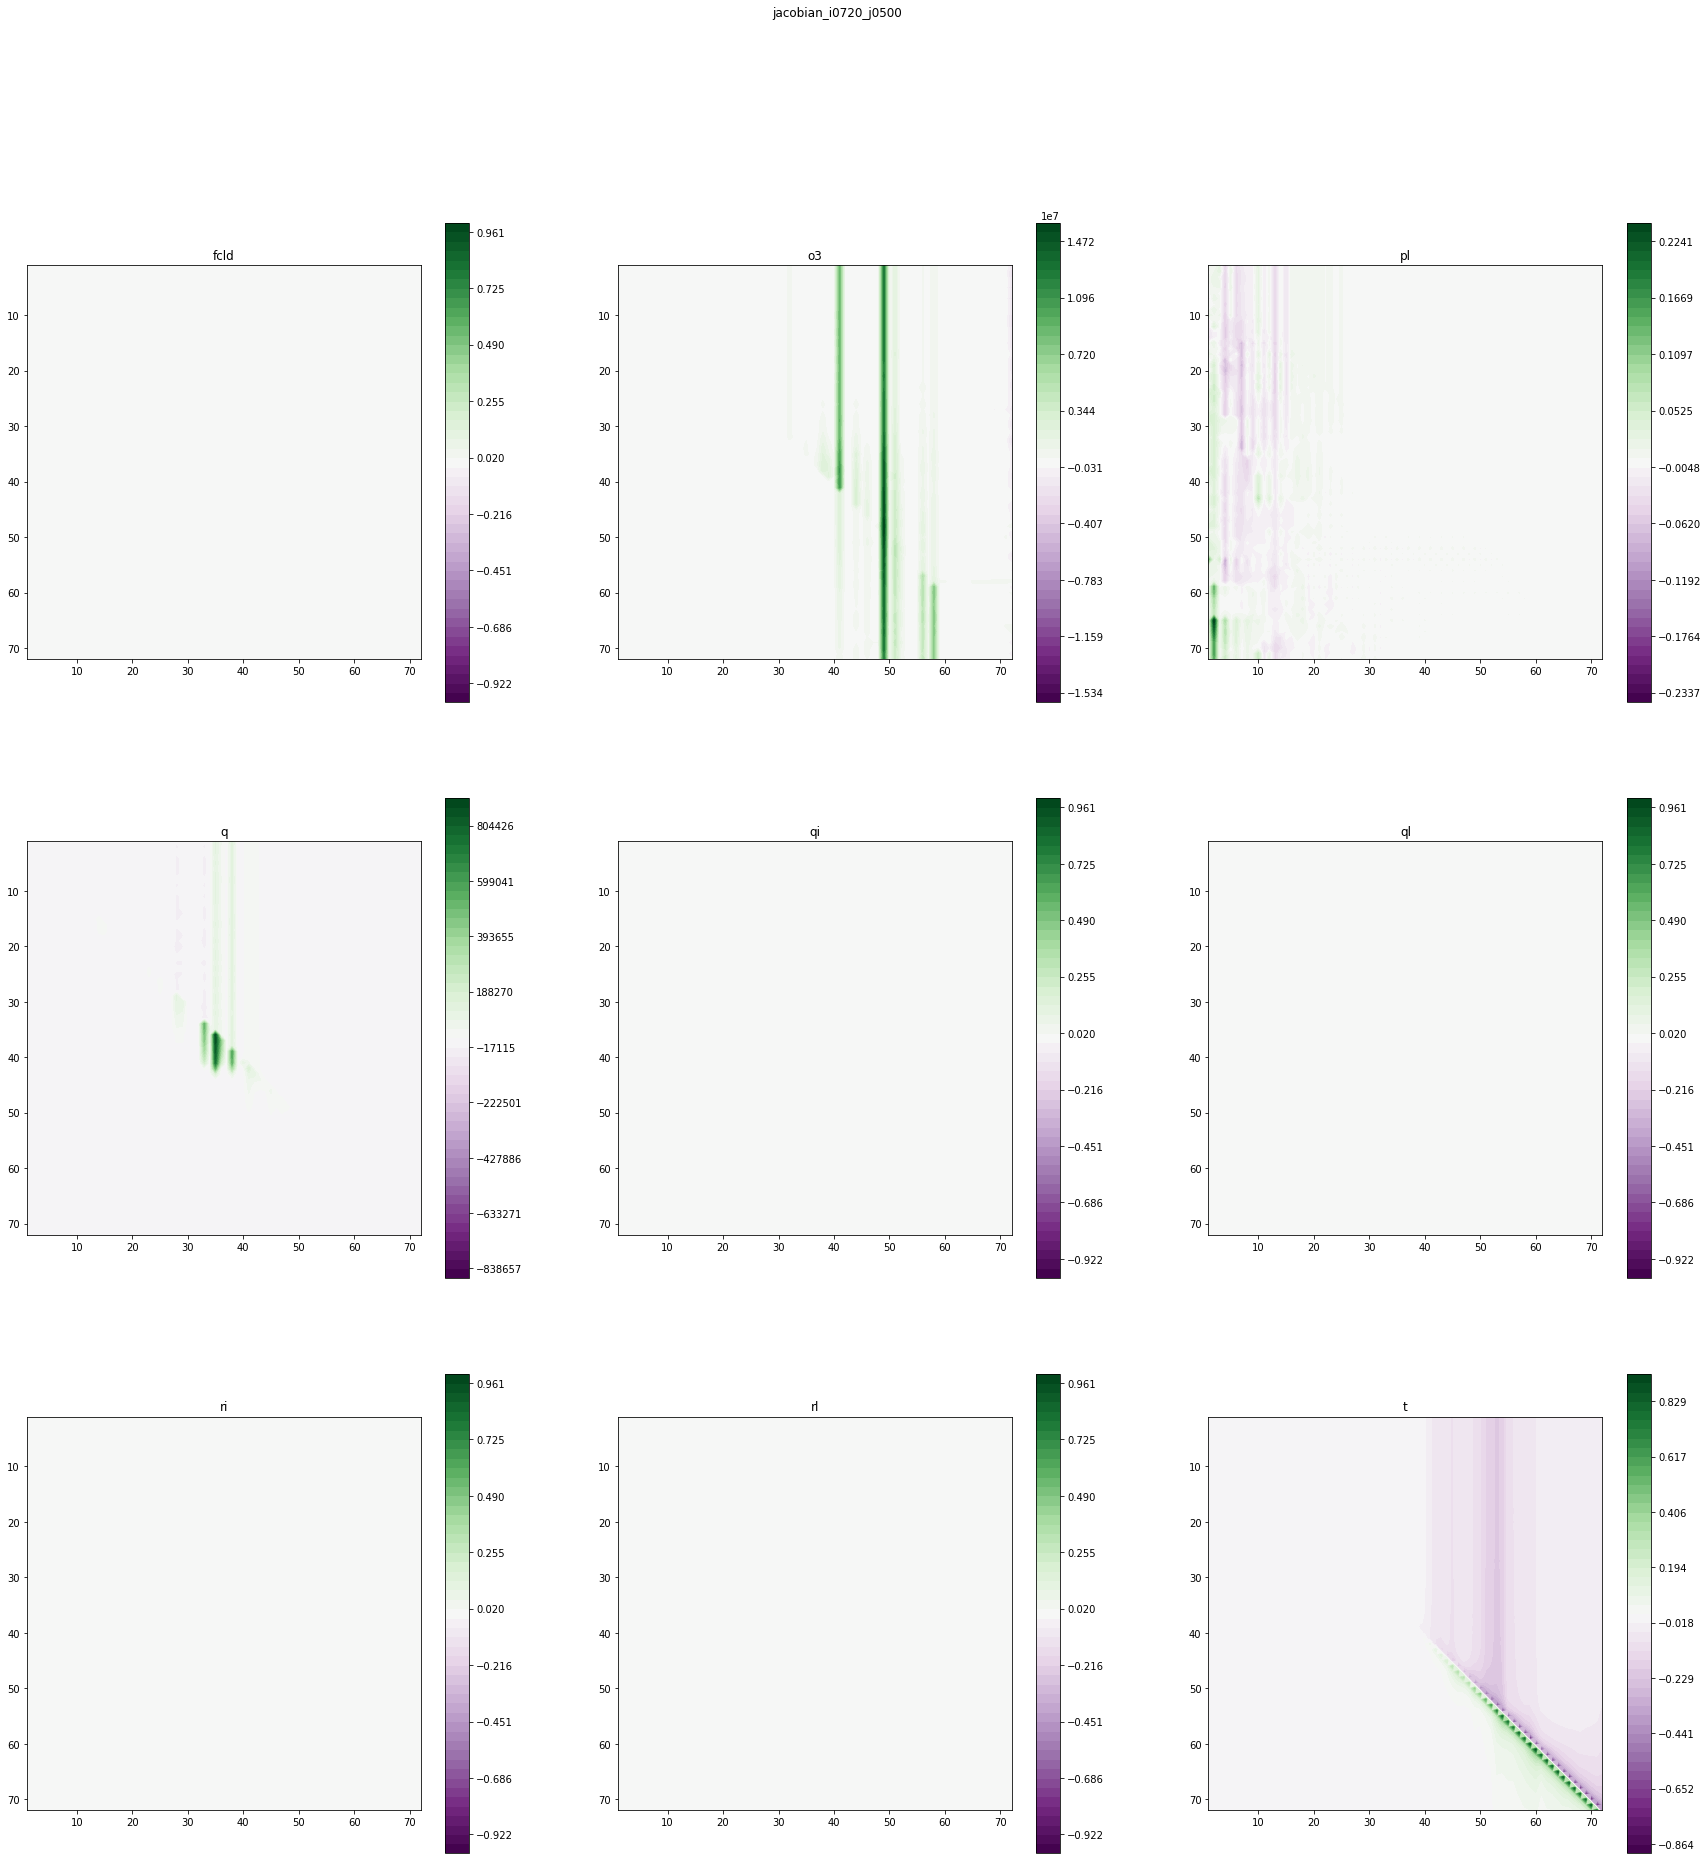

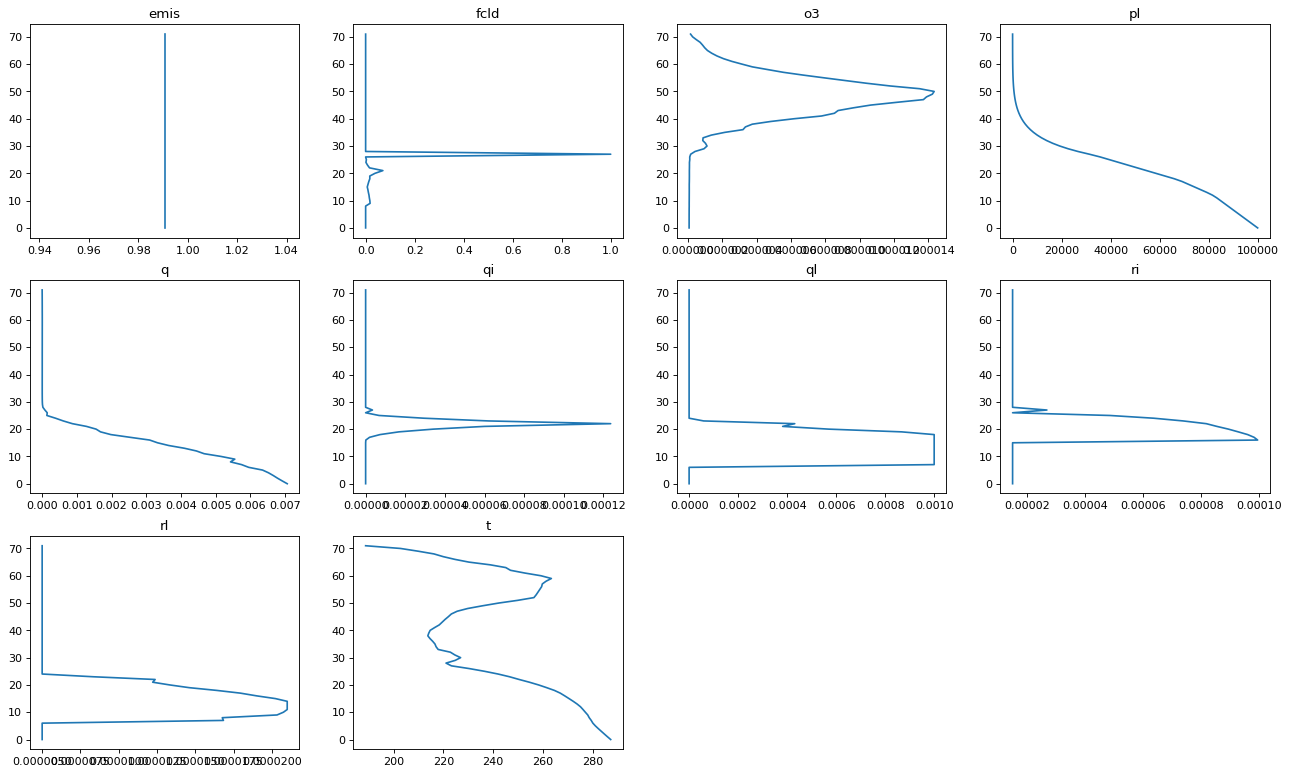

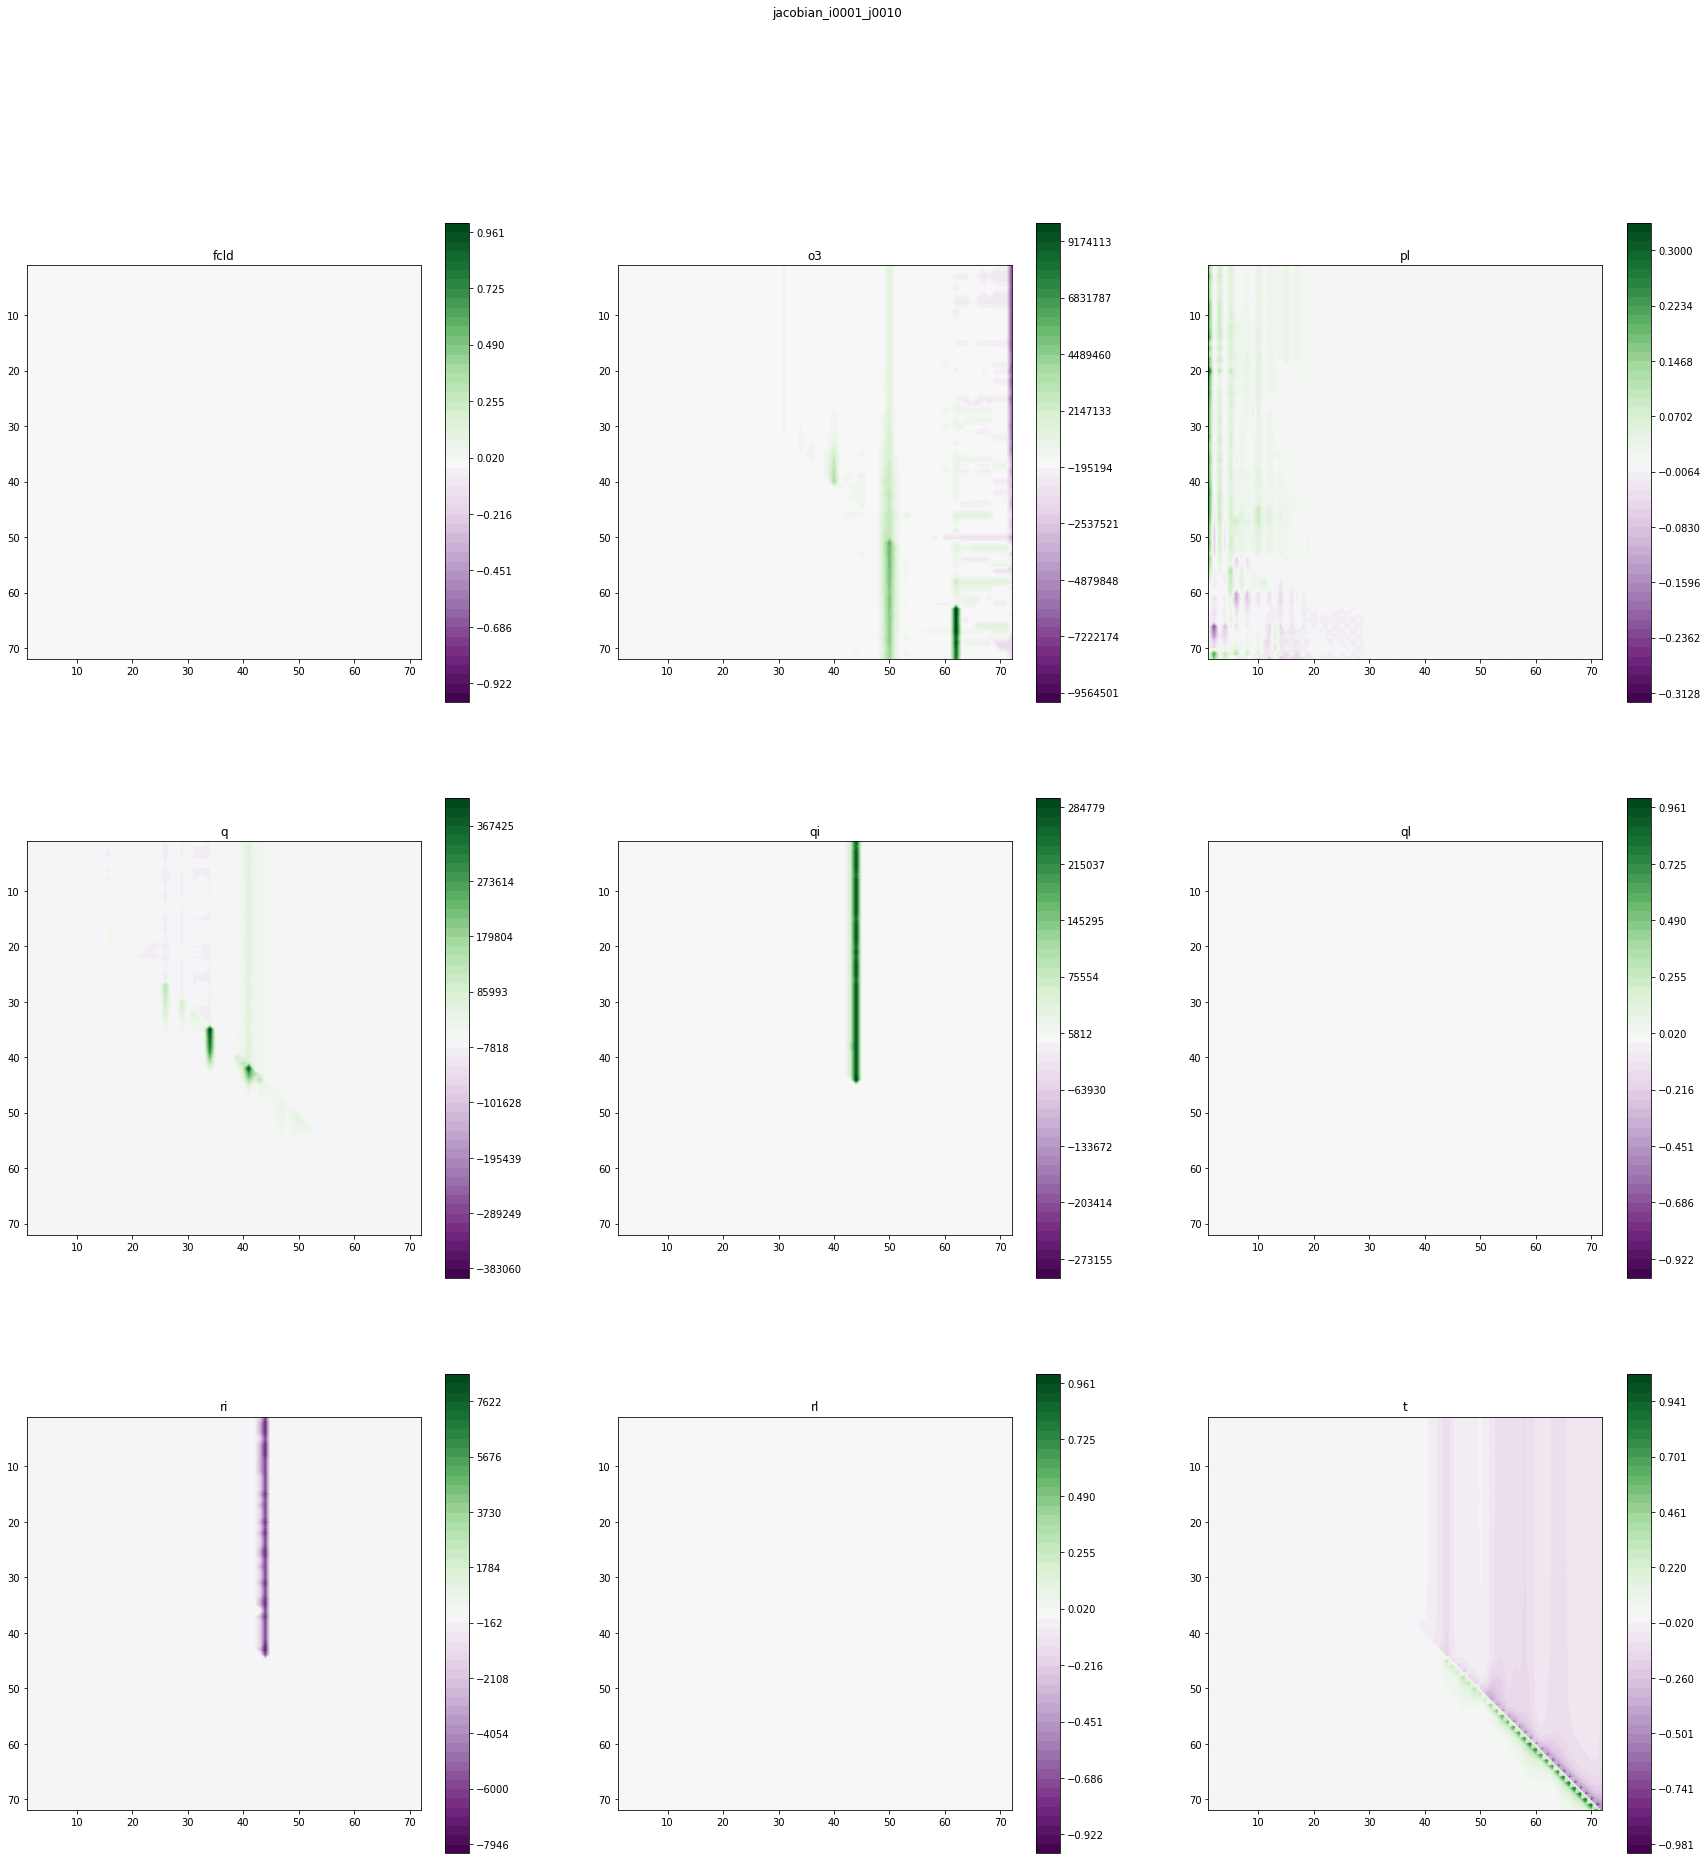

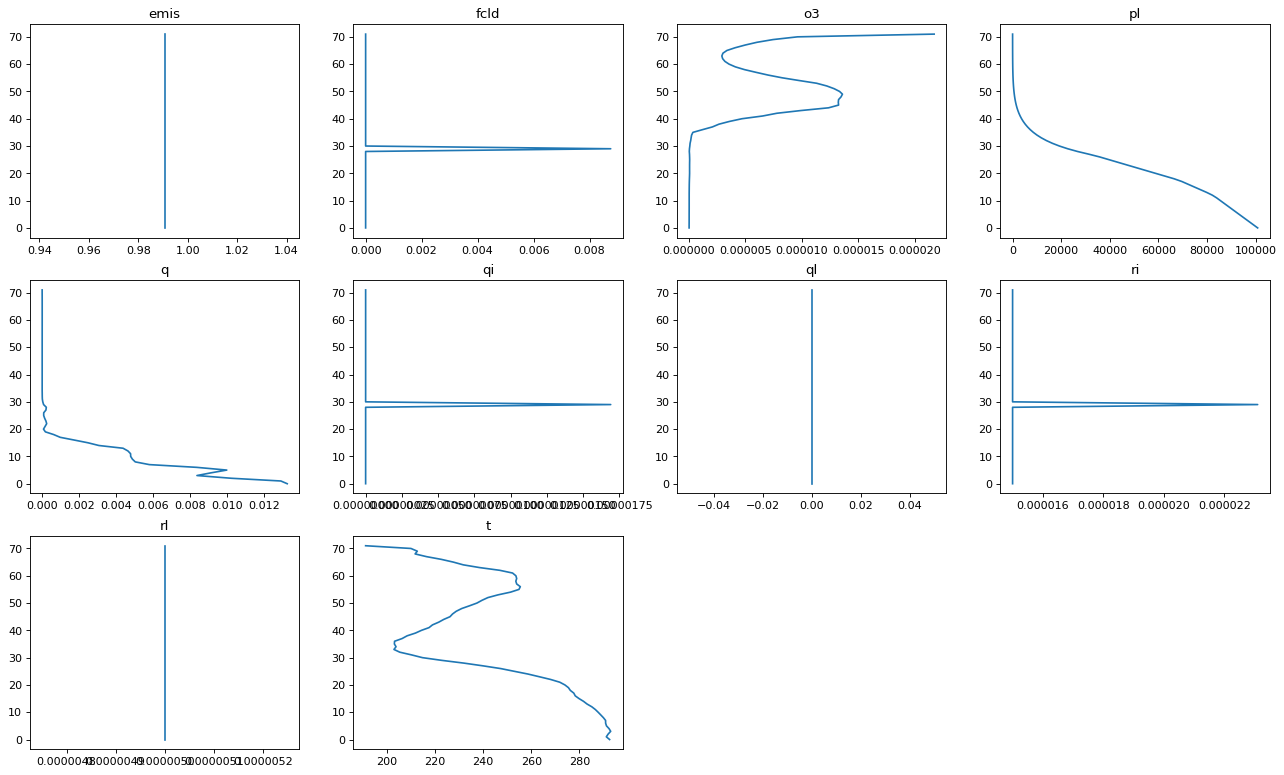

In [149]:
for i,J in enumerate(J_fortran):
    F=F_and_plots(figsize=(30,30), shape=(3,3))
    F.f.suptitle(profiles[i])
    Sep_Var_show(F,J, header_x)
    Plot_Batch(xnc4[[i]], header_x)
    F.f.savefig(profiles[i]+'.jpg')

In [54]:
B =  Basic_Generator(folder=data_folder, batch_size=batch_size, train=True, shuffle=0)

In [76]:
B.X

Var        emis                                                          \
level        0       1       2       3       4       5       6       7    
0   0    0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    1    0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    2    0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    3    0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    4    0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    5    0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    6    0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    7    0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    8    0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    9    0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    10   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    11   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    12   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    13   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    14   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    15   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    16   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    17   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    18   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    19   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    20   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    21   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    22   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    23   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    24   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    25   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    26   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    27   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    28   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    29   0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
...         ...     ...     ...     ...     ...     ...     ...     ...   
143 834  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    835  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    836  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    837  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    838  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    839  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    840  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    841  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    842  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    843  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    844  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    845  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    846  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    847  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    848  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    849  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    850  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    851  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    852  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    853  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.9907   
    854  0.9907  0.9907  

4 644


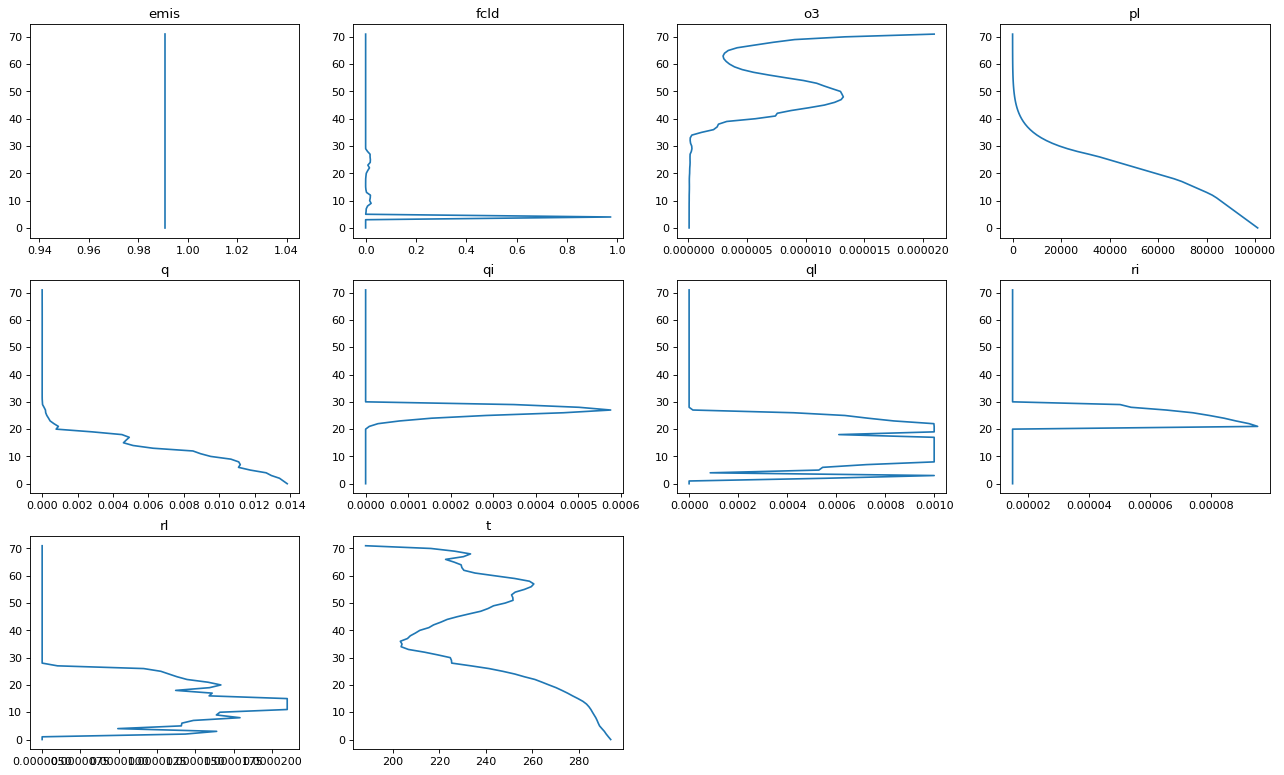

In [130]:
len(train_generator)
train_generator.dimensions
Plot_Batch(train_generator[a][0][[b]], header_x)

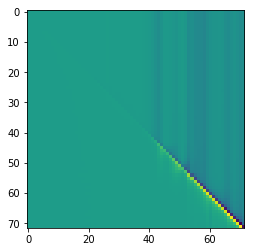

In [153]:
plt.imshow(J_fortran[0][-1])

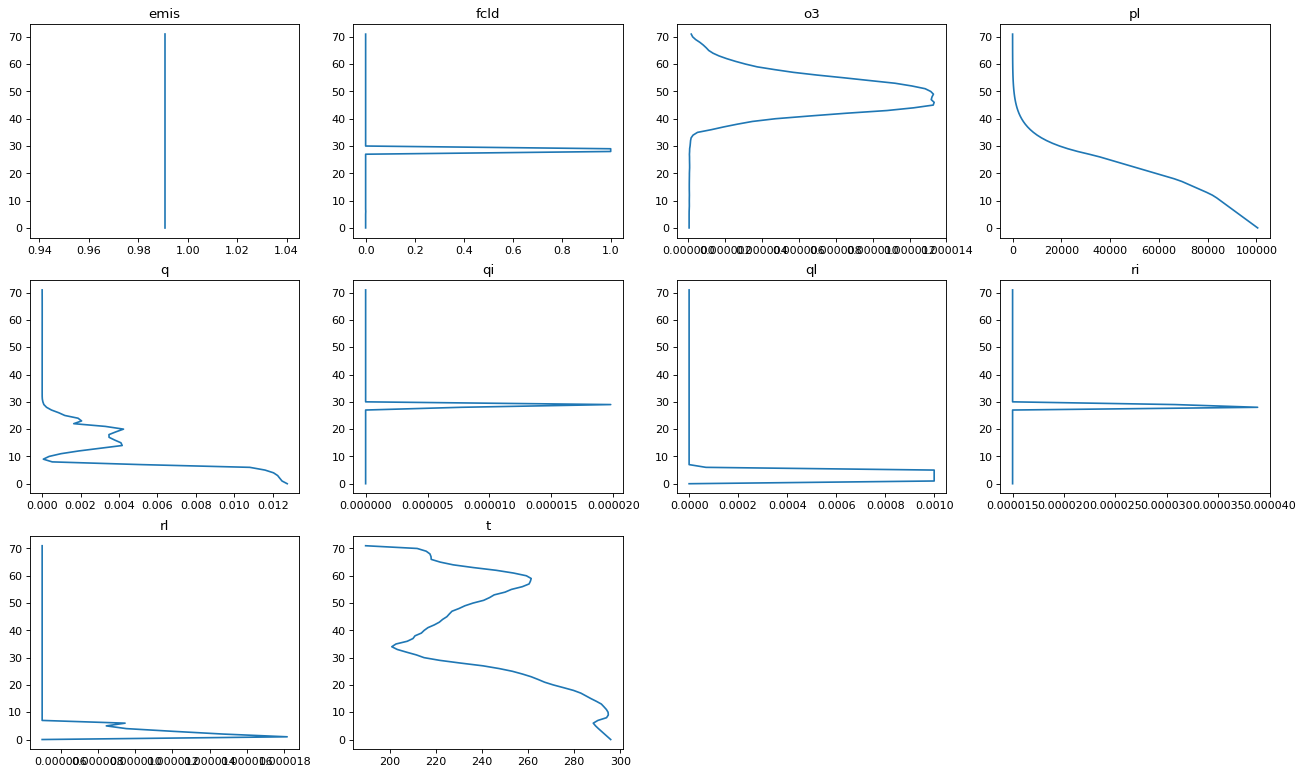

In [120]:
F = Dataset('Data_net4/401_600/f522_dh.trainingdata_in.lcv.20190401_0600z.nc4')

def Produce_x_nc4(fh, i0,j0, header_x):
    z = np.arange(1, 73, 1)
    flag=True
    x_0 = np.zeros((72, len(header_x)))
    for i,v in enumerate(header_x):
        if v=='emis':
            x_0[:,i] = fh.variables[v][0,j0-1,i0-1]
        if not 'emis' in v and not 'ts' in v:
            x_0[:,i] = fh.variables[v][0,:,j0-1,i0-1]
    return(x_0)

xnc4 = Produce_x_nc4(F, 720, 31, header_x)
Plot_Batch(np.expand_dims(xnc4,axis=0), header_x)

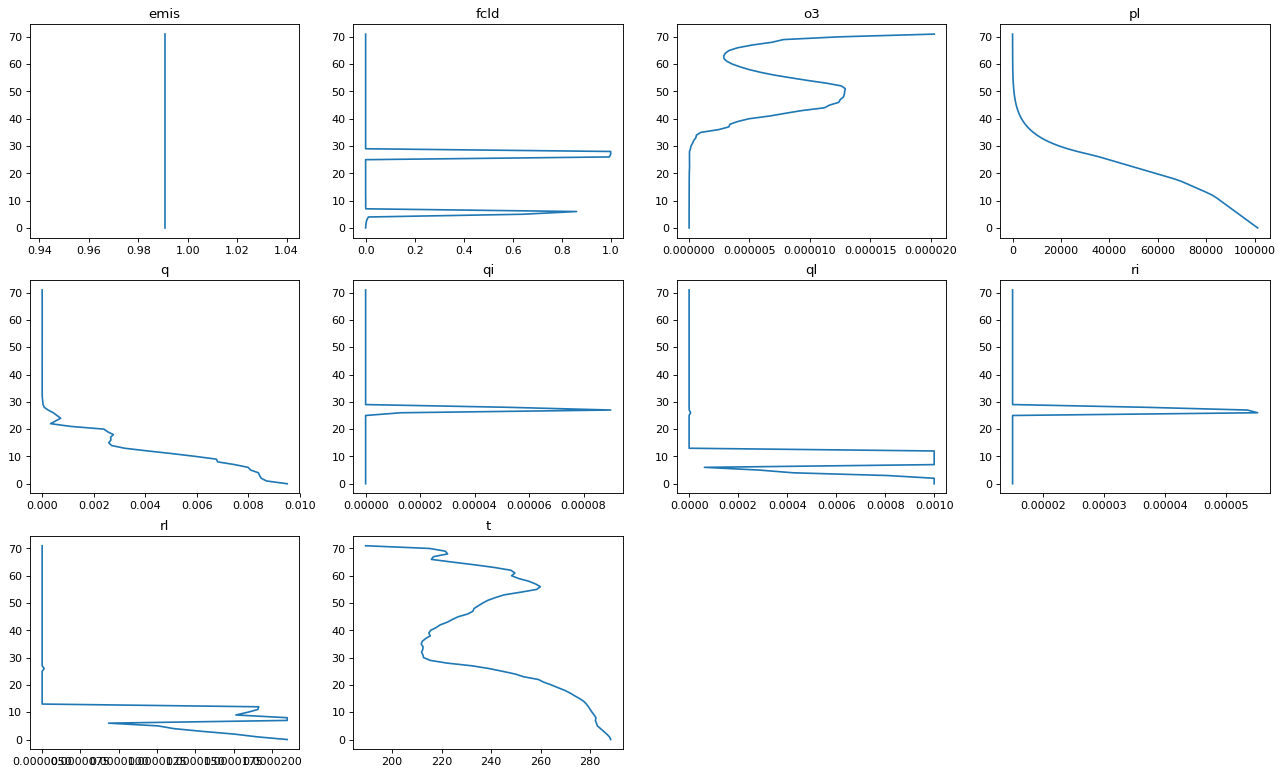

In [102]:
Plot_Batch(train_generator[19440][0][[30]], header_x)

In [96]:
import tqdm

G=[]
for i in tqdm.tqdm(range(72)):
    gradients = K.gradients(M.get_output_at(0)[:,i],M.input)
    gradients_f = K.function( [M.input] , [gradients[0]] )
    G.append(gradients_f([x[[0]]])[0])

G=np.array(G)
G = G[:,0,:,:]
G = G.swapaxes(1,2)
G = G.swapaxes(0,1)
Gorigin =G.copy()
for i in range(G.shape[0]):
    G[i] = G[i].T

100%|██████████| 72/72 [02:28<00:00,  3.14s/it]


In [112]:
np.save("NoPrepopGrad0001_0001", G)

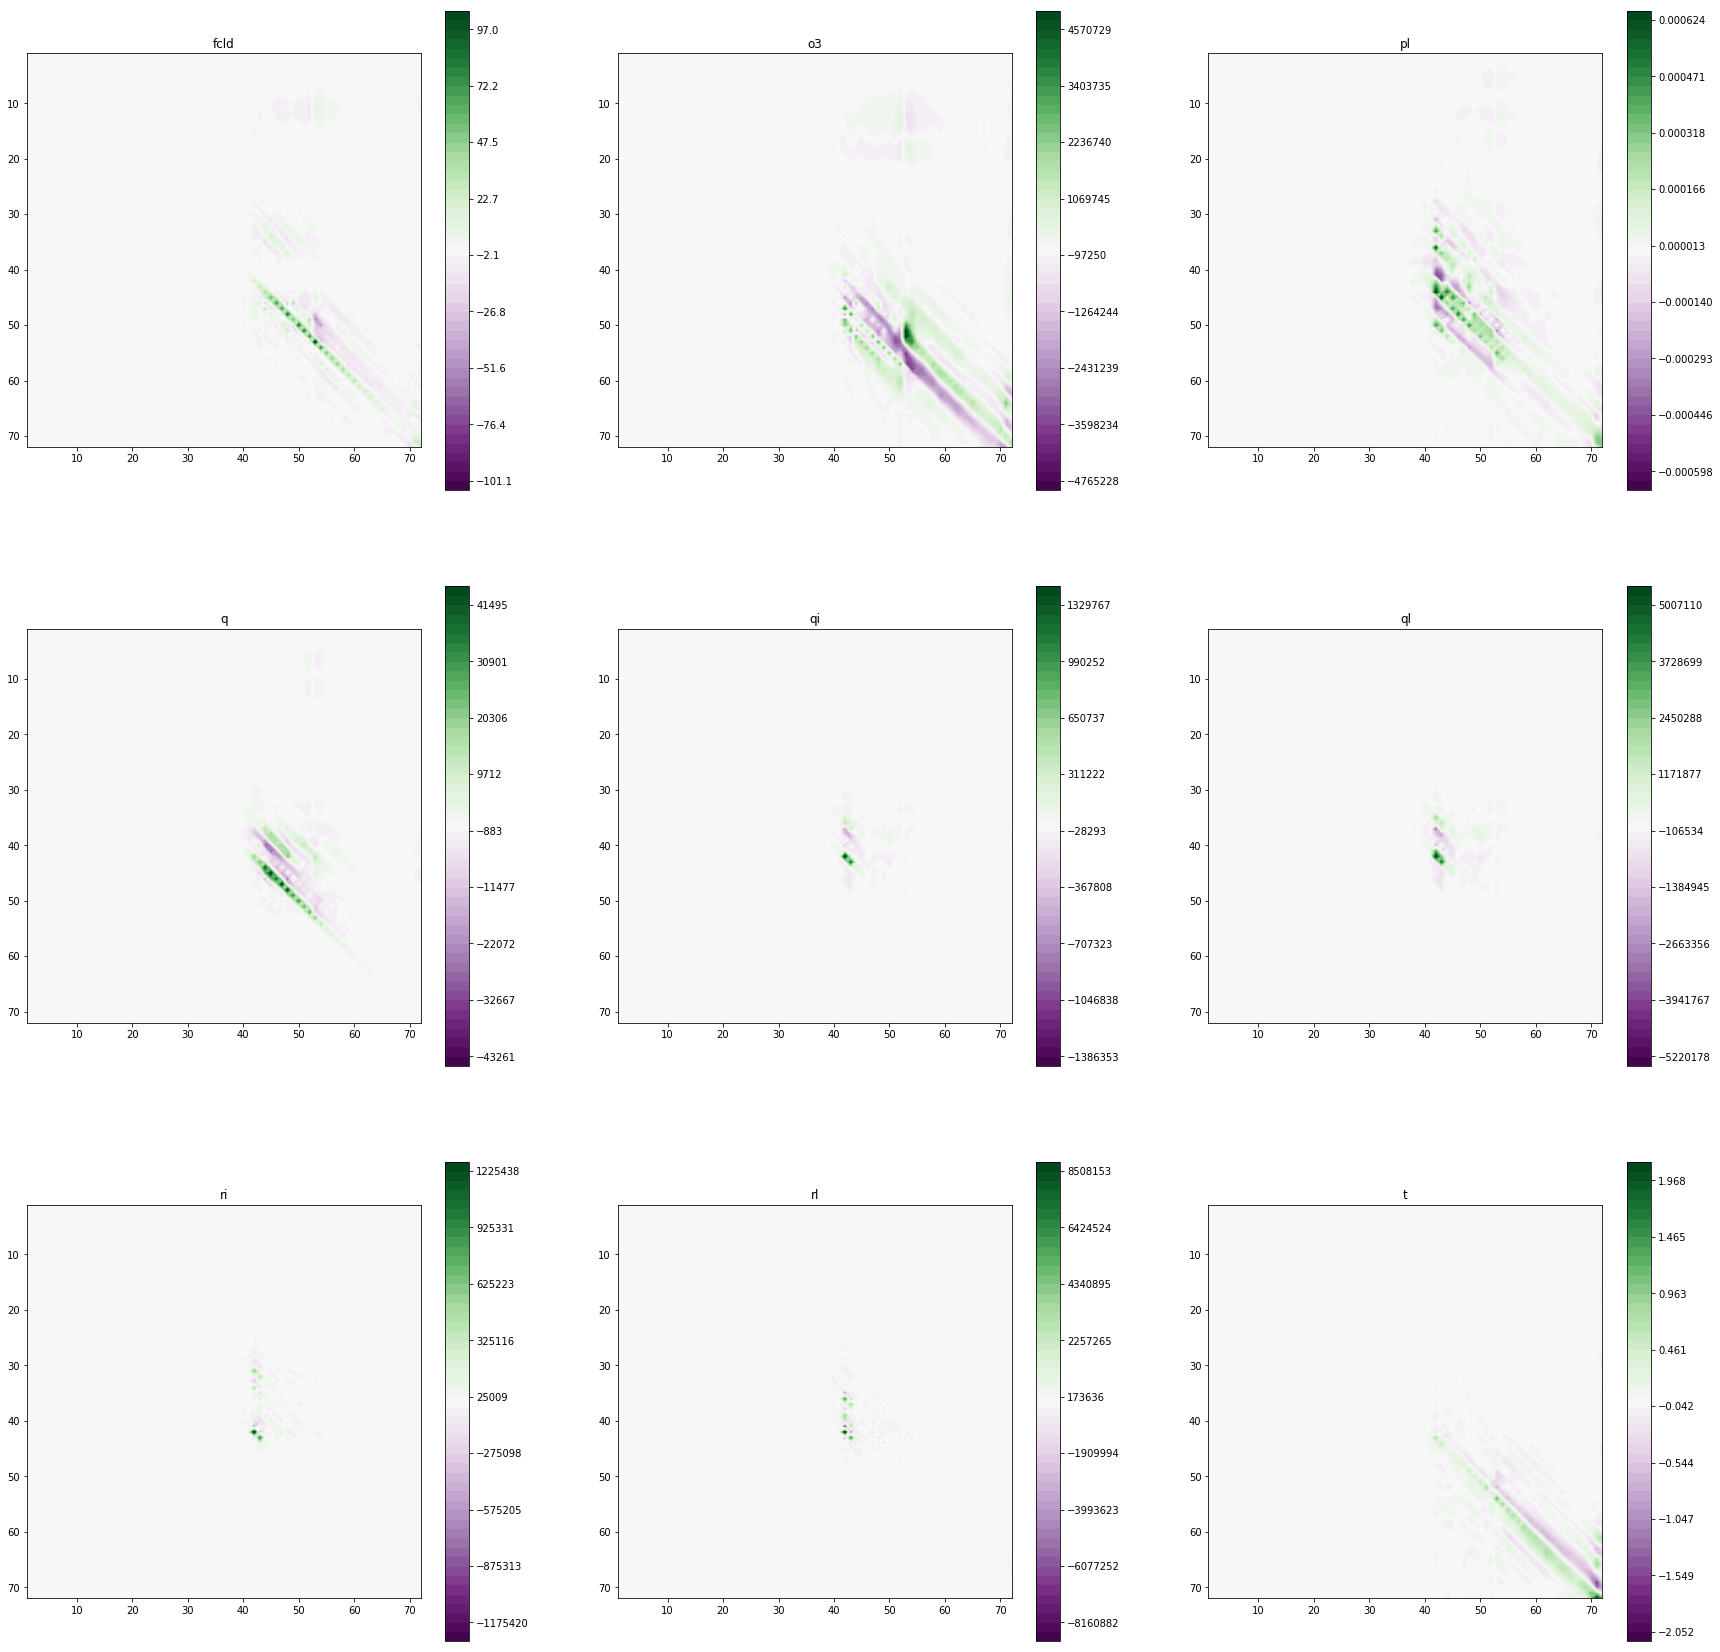

In [122]:
F=F_and_plots(figsize=(30,30), shape=(3,3))
Sep_Var_show(F,G, header_x)

In [98]:
import tqdm 
x=xmin.copy()

_, lev, n_var= x.shape
J = np.zeros((lev)) 

emis = x[0,0,0]
emis = np.array([emis]).reshape(-1,1)

x0 = x[:,:,1:]
    
repeat = lambda x : K.repeat(x, 72)
concat0 = lambda x : K.concatenate([x,x0], axis=-1)
Lcopy = keras.layers.Lambda(repeat)
Lcont = keras.layers.Lambda(concat0)
m2 = keras.Sequential()
m2.add(Lcopy)
m2.add(Lcont)
m2.add(M)
m2.predict(emis)
Gemis=[]
for i in tqdm.tqdm(range(72)):
    gradient2s = K.gradients(m2.get_output_at(0)[:,i], m2.input)
    gradient2s_f = K.function( [m2.input] , [gradient2s[0]] )
    Gemis.append(gradient2s_f([emis])[0])

100%|██████████| 72/72 [04:22<00:00,  4.87s/it]


In [99]:
Gemis = np.array(Gemis)[:,:,0].T

Text(0.5, 0.98, 'Emis Grad')

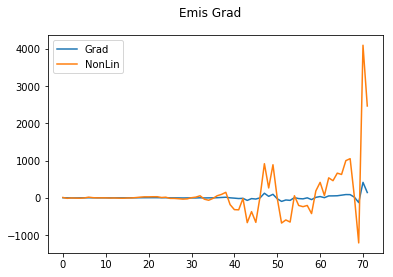

In [100]:
plt.plot(-Gemis[0]);
plt.plot(J_emis[0]*10000)
plt.legend(['Grad', 'NonLin'])
plt.suptitle('Emis Grad')

In [132]:
import tensorflow as tf
emis = tf.cast([emis], tf.float32)
#emis = tf.reshape(emis, shape=(1,1))

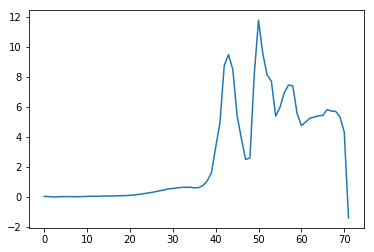

In [166]:
plt.plot(y[0]);

In [64]:
G0 = np.load('Tf_grad_best_model.npy')

In [230]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal

def Sep_Var_show(F,J, header_x, T=True):
    """
    Show the Jacobian of each variable
    F : F and Plot class element of len len(header_x)
    header_x : list of variables
    J gradient of size (lev, n_var*lev)
    """
    l , c = J.shape
    n_var = len(header_x)
    lev = c//n_var
    for i in range(len(header_x)):
        img = J[:, lev*i:lev*(i+1) ]
        maxf = np.max(np.abs(img))
        if maxf == 0:
            maxf = 1.0
        incf = 2*maxf/51.
        clevs = np.arange(-maxf,maxf+incf,incf)

        F[i].imshow(img, 
                    cmap='PRGn'
                   )
        #im = ax.contourf(z, z, np.transpose(field), clevs, cmap = 'PRGn')  

        F[i].set_title(header_x[i])

def Jacobian_relative(M,x, dt):
    """
    Compute the Jacobian of x
    x has shape (1, lev, n_var)
    M product an output of size (1, lev)
    """
    _, lev, n_var= x.shape
    Jac = np.zeros((n_var, lev, lev))
    P0 = np.zeros((lev*n_var, lev))
    # could be more optimize [l steps instead of l*n_var]
    # Using one pred of size lev*n_var produce odd result, lev*header_x pred
    # which is not optimal
    
    for v in range(n_var):
        for l in range(lev):
            x0 = x.copy()
            x0[0,l , v] += x[0,l,v]/dt
            P0[v*lev+l] = M.predict(x0)
    P1 = M.predict(x)
    return (P1-P0).T


def Sep_Var_Gradient(J, header_x):
    """
    Rshape J of size(lev, header_x*lev) to size (header_x, lev, lev)
    """
    l,c = J.shape
    n_var = len(header_x)
    lev = c//n_var
    J = [J[:, lev*i:lev*(i+1) ] for i in range(len(header_x))]
    return(np.array(J))

Jr = Jacobian_relative(M,xmin, 1000)

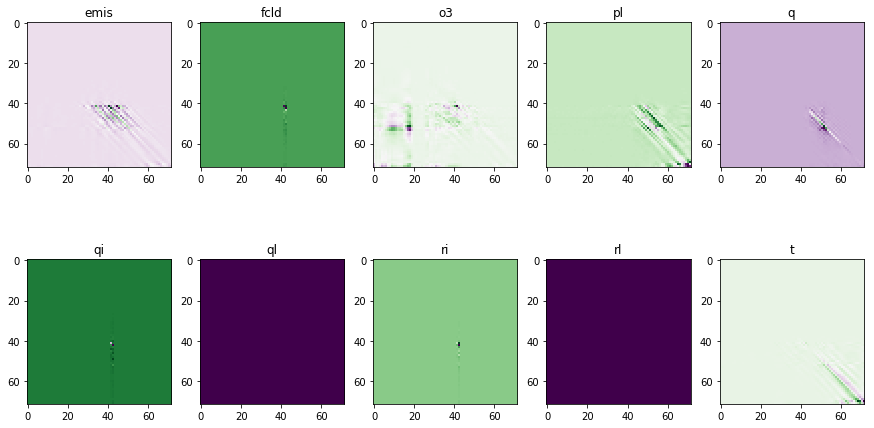

In [232]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,Jr, header_x)

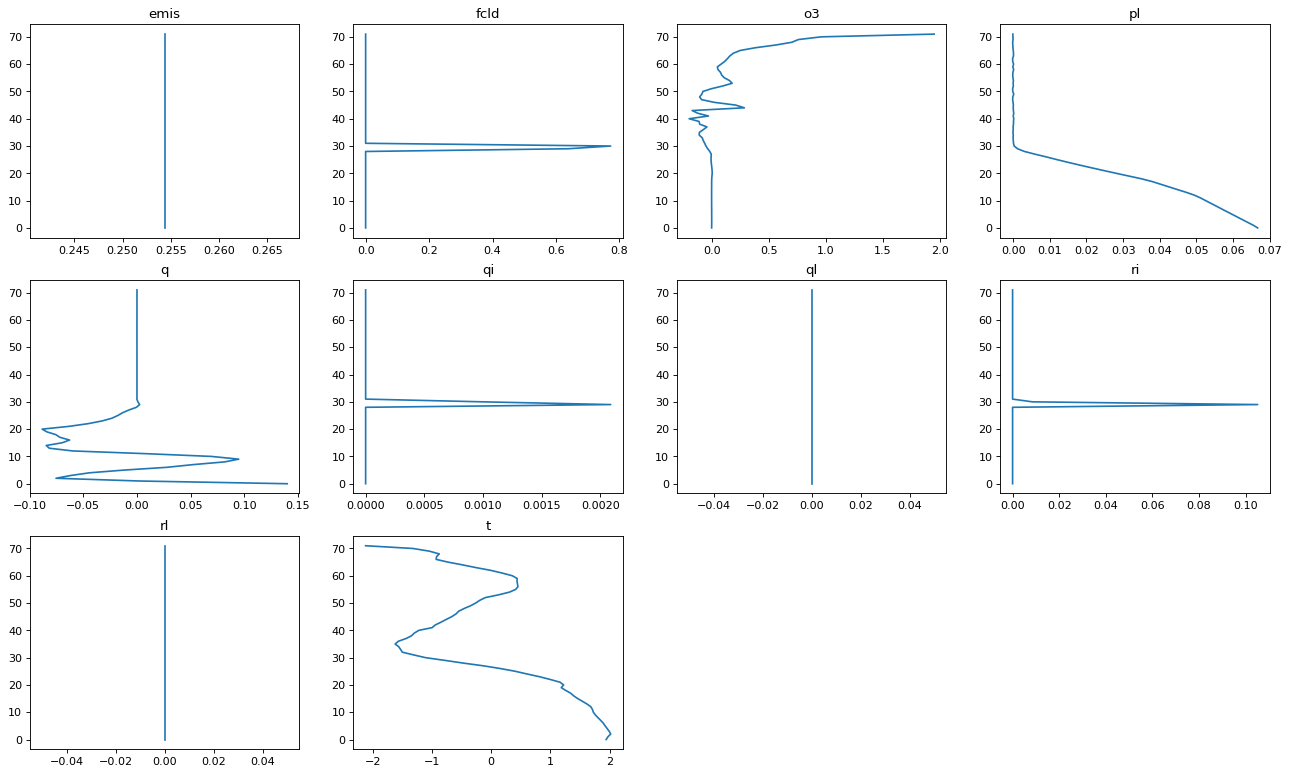

In [224]:
Plot_Batch(xmin, header_x)

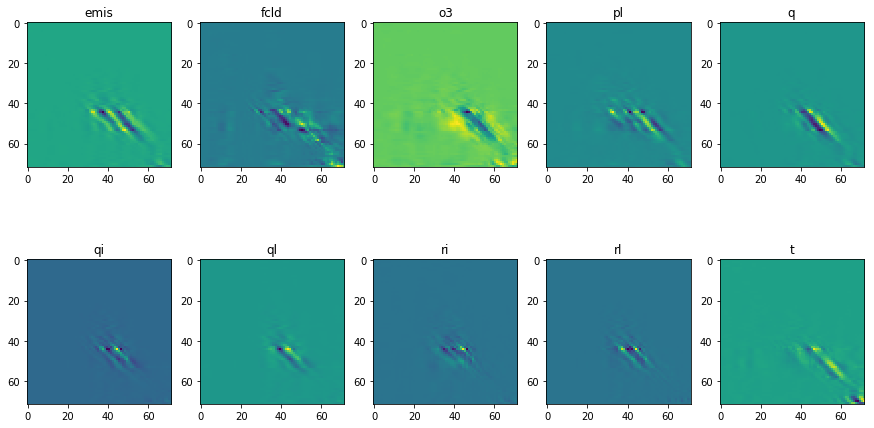

In [30]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,G0, header_x)

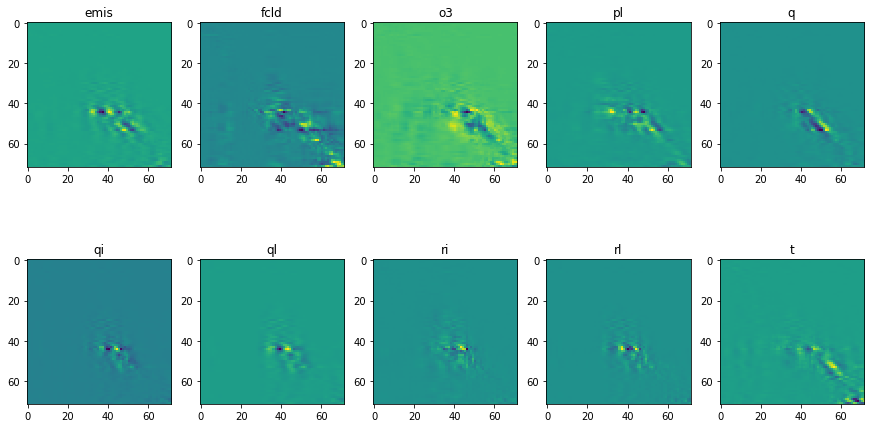

In [33]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,10000*J+G0, header_x)

In [52]:
for j,i in enumerate(G2-J2):
    print(header_x[j], np.max(i), np.min(i))

emis 3.4753172397613525 -5.038313627243042
fcld 4.450602293014526 -3.2322890758514404
o3 0.9157004952430725 -2.905653238296509
pl 4.1315600872039795 -3.7754268646240234
q 49.70502281188965 -54.84940028190613
qi 69.43060564994812 -36.00625824928284
ql 247.81062531471252 -280.3574583530426
ri 9.647634029388428 -5.988334655761719
rl 25.624382734298706 -15.990925073623657
t 3.0675272941589355 -4.052147626876831


In [49]:
for j,i in enumerate(G2):
    print(header_x[j], np.max(i), np.min(i))

emis 3.4751897 -5.038152
fcld 4.450342 -3.2321835
o3 0.91567427 -2.9055223
pl 4.131408 -3.7752972
q 49.702225 -54.847145
qi 69.42737 -36.005356
ql 247.80237 -280.35013
ri 9.647031 -5.988172
rl 25.623098 -15.990633
t 3.0673404 -4.051973


In [50]:
for j,i in enumerate(J2*10000):
    print(header_x[j], np.max(i), np.min(i))

emis 3.2377243041992188 -2.1457672119140625
fcld 2.32696533203125 -3.8766860961914062
o3 1.4138221740722656 -0.6794929504394531
pl 1.7452239990234375 -2.4962425231933594
q 31.156539916992188 -28.03802490234375
qi 18.143653869628906 -32.37485885620117
ql 139.923095703125 -111.38439178466797
ri 2.8443336486816406 -6.031990051269531
rl 7.419586181640625 -12.843608856201172
t 2.0444393157958984 -2.016127109527588


In [47]:
from generator import Full_Diff_Generator
test_gen = Full_Diff_Generator(folder='Data3', batch_size=batch_size, train=False, preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0)
test_gen.list_files = [24]

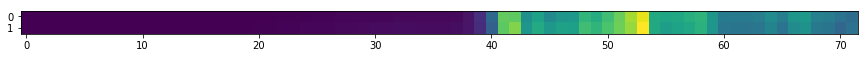

In [50]:
import tensorflow as tf
# CHECKING IMPACT OF LOWER LAYER
x,y = test_gen[100]

y0 = M.predict(x)

i = M_Up.get_input_at(0)
o = M_Up.get_output_at(0)

Up_model = K.function([i],[o])

i1 = M_unet.get_input_at(0)
o1 = M_unet.get_output_at(0)

o2 = M_unet.get_layer('Reshape').output
o3 = M_unet.get_layer('elu_301').get_output_at(0)
o4 = M_unet.get_layer('Conv3_301').get_output_at(0)
o5 = M_unet.get_layer('linear_302').get_output_at(0)

Second_model = K.function( [i1],[o1])
Dense_layer = K.function( [i1],[o2])
Antepen_layer = K.function( [i1],[o3])
#Last_layer = K.function( [i1],[o4])
Last_layer = K.function( [i1],[o5])


#img = Dense_layer(First_model([x]))[0]
img = Last_layer( Up_model([x]))[0]

#Antepen_layer(Up_model([x]))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow((np.mean(abs(img),axis=0).T))
#F = K.function(I,O)
#F([tf.cast(x,tf.float32)])

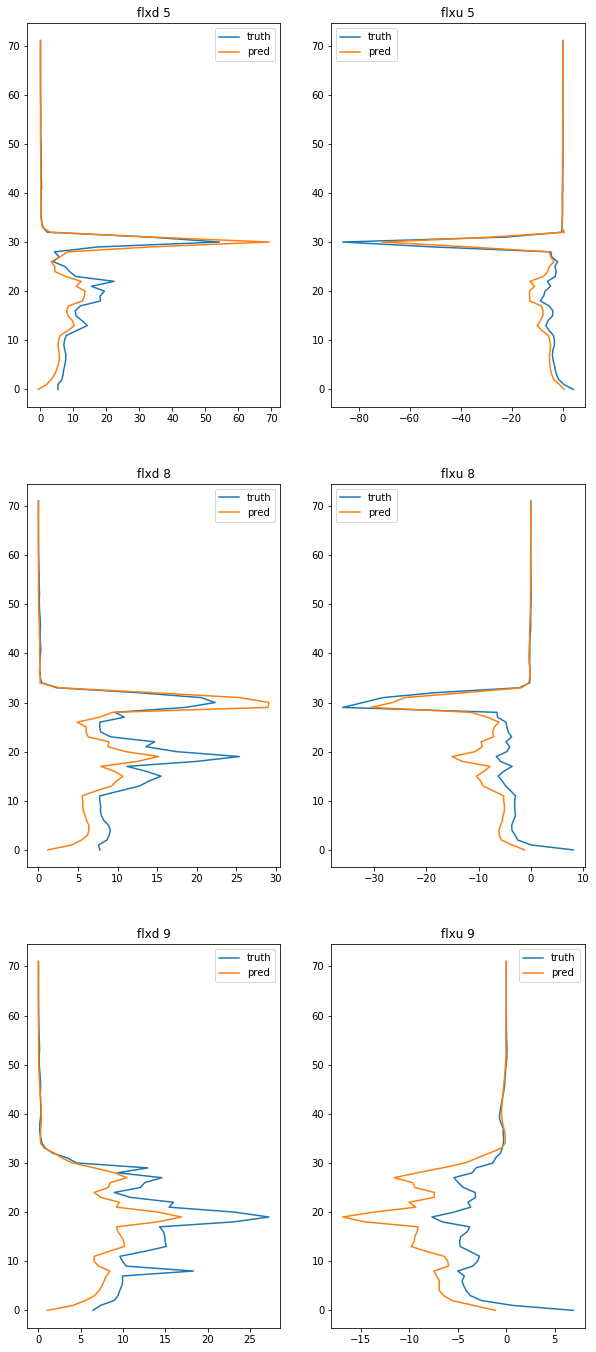

In [76]:
def Plot_diff(F, y,y0, header_y, lev=72, J = [0], titles=False):
    for l in range(len(header_y)):
        for ind,i in enumerate(J):
            F[ind*len(header_y) + l].plot(np.flip(y[i,:,l].T) , np.arange(lev))
            F[ind*len(header_y) + l].plot(np.flip(y0[i,:,l].T) , np.arange(lev))
            F[ind*len(header_y) + l].legend(["truth", "pred"])
            if titles !=False:
                F[ind*len(header_y) + l].set_title(header_y[l] + ' '+ str(titles[ind]))
                

J=[5,8,9]
F = F_and_plots(figsize=(5*2,len(J)*8), shape=(len(J), 2))
Plot_diff(F, y, img, ['flxd', 'flxu'], J=J, titles=J)

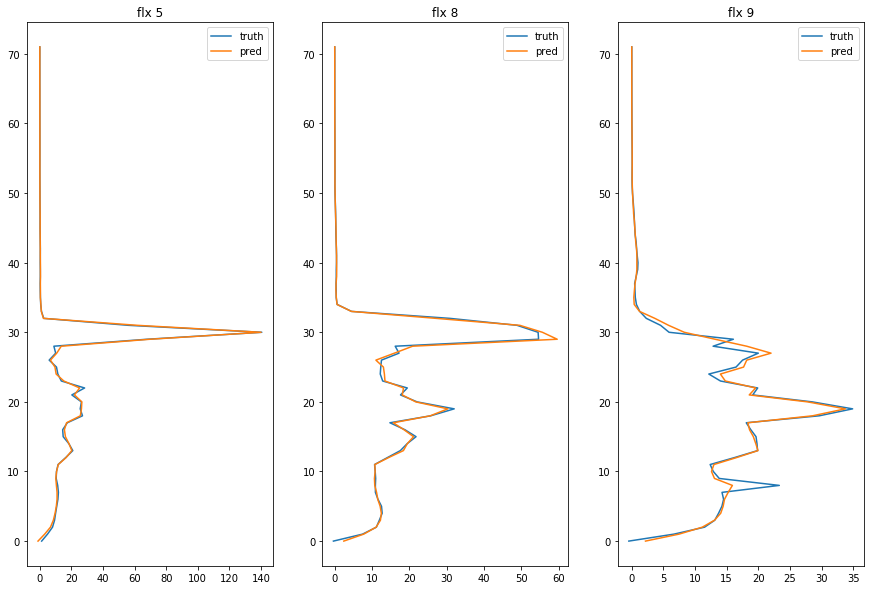

In [73]:
F = F_and_plots(figsize=(15,10), shape=(1,len(J)))
Plot_diff(F, y[:,:,[0]]-y[:,:,[1]], y0.reshape(32,72,1), ['flx'], J=J, titles=J)

In [70]:
y0.shape

(32, 72)